## Sales of summer clothes in E-commerce Wish
https://www.kaggle.com/datasets/jmmvutu/summer-products-and-sales-in-ecommerce-wish

European Summer Clothes sales from Wish E-commerce Platform

In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

Import Dataset with Excluded and Rearranged Columns

In [378]:
sumclo_df = pd.read_csv('summer-products-with-rating-and-performance_2020-08.csv')

# exclude column
sumclo_df = sumclo_df.loc[:, ~sumclo_df.columns.isin(['title','currency_buyer', 'tags', 'merchant_name', 
                'merchant_info_subtitle', 'merchant_has_profile_picture', 'merchant_profile_picture', 
                'product_url', 'product_picture', 'theme', 'crawl_month'])]

# moving product id column into the first ordered 
sumclo_df = sumclo_df[['product_id','title_orig', 'price', 'retail_price', 'units_sold', 'uses_ad_boosts',
       'rating', 'rating_count', 'rating_five_count', 'rating_four_count','rating_three_count', 
       'rating_two_count', 'rating_one_count','badges_count', 'badge_local_product', 'badge_product_quality',
       'badge_fast_shipping', 'product_color', 'product_variation_size_id','product_variation_inventory', 
       'shipping_option_name','shipping_option_price', 'shipping_is_express', 'countries_shipped_to',
       'inventory_total', 'has_urgency_banner', 'urgency_text','origin_country', 'merchant_title', 
       'merchant_rating_count', 'merchant_rating', 'merchant_id']]

# rename columns title orig into product title
sumclo_df.rename(columns={'title_orig':'product_title'}, inplace=True)
sumclo_df.head()

,product_id,product_title,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,...,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,urgency_text,origin_country,merchant_title,merchant_rating_count,merchant_rating,merchant_id
0,5e9ae51d43d6a96e303acdb0,2020 Summer Vintage Flamingo Print Pajamas Se...,16.00,14,100,0,3.76,54,26.0,8.0,...,0,34,50,1.0,Quantité limitée !,CN,zgrdejia,568,4.128521,595097d6a26f6e070cb878d1
1,58940d436a0d3d5da4e95a38,Women's Casual Summer Sleeveless Sexy Mini Dress,8.00,22,20000,1,3.45,6135,2269.0,1027.0,...,0,41,50,1.0,Quantité limitée !,CN,SaraHouse,17752,3.899673,56458aa03a698c35c9050988
2,5ea10e2c617580260d55310a,2020 New Arrival Women Spring and Summer Beach...,8.00,43,100,0,3.57,14,5.0,4.0,...,0,36,50,1.0,Quantité limitée !,CN,hxt520,295,3.989831,5d464a1ffdf7bc44ee933c65
3,5cedf17ad1d44c52c59e4aca,Hot Summer Cool T Shirt for Women Fashion Tops...,8.00,8,5000,1,4.03,579,295.0,119.0,...,0,41,50,NaN,NaN,CN,allenfan,23832,4.020435,58cfdefdacb37b556efdff7c
4,5ebf5819ebac372b070b0e70,Women Summer Shorts Lace Up Elastic Waistband ...,2.72,3,100,1,3.10,20,6.0,4.0,...,0,35,50,1.0,Quantité limitée !,CN,youngpeopleshop,14482,4.001588,5ab3b592c3911a095ad5dadb


## Glossary
- uses_ad_boosts, penjual membayar ads untuk meningkatkan penjualan produk dengan platform
- badges_local, penanda kalau itu produk lokal
- bades_product_quality, penanda kalau pembeli konsiten kasih evaluasi yang baik
- badge_fast_ship, penanda kalau pengiriman cepat
- product_variation_inventory, maximal quantity yang dibeli sesuai ketentuan penjual
- shipping_is_express, jika menggunakan pengiriman express
- has_urgency_banner, banner agar produk segera dibeli karena jumlah terbatas atau diskon

In [41]:
sumclo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   product_id                   1573 non-null   object 
 1   product_title                1573 non-null   object 
 2   price                        1573 non-null   float64
 3   retail_price                 1573 non-null   int64  
 4   units_sold                   1573 non-null   int64  
 5   uses_ad_boosts               1573 non-null   int64  
 6   rating                       1573 non-null   float64
 7   rating_count                 1573 non-null   int64  
 8   rating_five_count            1528 non-null   float64
 9   rating_four_count            1528 non-null   float64
 10  rating_three_count           1528 non-null   float64
 11  rating_two_count             1528 non-null   float64
 12  rating_one_count             1528 non-null   float64
 13  badges_count      

In [380]:
sumclo_df.isnull().sum().sort_values(ascending=False).head(11)

product_id               0
product_title            0
merchant_rating          0
merchant_rating_count    0
merchant_title           0
origin_country           0
urgency_text             0
has_urgency_banner       0
inventory_total          0
countries_shipped_to     0
shipping_is_express      0
dtype: int64

In [43]:
sumclo_df[sumclo_df.duplicated()].count()

product_id                     34
product_title                  34
price                          34
retail_price                   34
units_sold                     34
uses_ad_boosts                 34
rating                         34
rating_count                   34
rating_five_count              32
rating_four_count              32
rating_three_count             32
rating_two_count               32
rating_one_count               32
badges_count                   34
badge_local_product            34
badge_product_quality          34
badge_fast_shipping            34
product_color                  34
product_variation_size_id      34
product_variation_inventory    34
shipping_option_name           34
shipping_option_price          34
shipping_is_express            34
countries_shipped_to           34
inventory_total                34
has_urgency_banner              5
urgency_text                    5
origin_country                 33
merchant_title                 34
merchant_ratin

In [4]:
# statistical descriptive of numerical data
display(sumclo_df.describe())
# statistical descriptive of categorical data
display(sumclo_df.describe(include=[object]))

,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,...,badge_product_quality,badge_fast_shipping,product_variation_inventory,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,merchant_rating_count,merchant_rating
count,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1528.000000,1528.000000,1528.000000,1528.000000,...,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,473.0,1.573000e+03,1573.000000
mean,8.325372,23.288620,4339.005086,0.432931,3.820896,889.659250,442.263743,179.599476,134.549738,63.711387,...,0.074380,0.012715,33.081373,2.345200,0.002543,40.456453,49.821360,1.0,2.649583e+04,4.032345
std,3.932030,30.357863,9356.539302,0.495639,0.515374,1983.928834,980.203270,400.516231,311.690656,151.343933,...,0.262472,0.112075,21.353137,1.024371,0.050379,20.301203,2.562799,0.0,7.847446e+04,0.204768
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,6.000000,1.000000,1.0,0.000000e+00,2.333333
25%,5.810000,7.000000,100.000000,0.000000,3.550000,24.000000,12.000000,5.000000,4.000000,2.000000,...,0.000000,0.000000,6.000000,2.000000,0.000000,31.000000,50.000000,1.0,1.987000e+03,3.917353
50%,8.000000,10.000000,1000.000000,0.000000,3.850000,150.000000,79.000000,31.500000,24.000000,11.000000,...,0.000000,0.000000,50.000000,2.000000,0.000000,40.000000,50.000000,1.0,7.936000e+03,4.040650
75%,11.000000,26.000000,5000.000000,1.000000,4.110000,855.000000,413.500000,168.250000,129.250000,62.000000,...,0.000000,0.000000,50.000000,3.000000,0.000000,43.000000,50.000000,1.0,2.456400e+04,4.161797
max,49.000000,252.000000,100000.000000,1.000000,5.000000,20744.000000,11548.000000,4152.000000,3658.000000,2003.000000,...,1.000000,1.000000,50.000000,12.000000,1.000000,140.000000,50.000000,1.0,2.174765e+06,5.000000


,product_id,title_orig,product_color,product_variation_size_id,shipping_option_name,urgency_text,origin_country,merchant_title,merchant_id
count,1573,1573,1532,1559,1573,473,1556,1573,1573
unique,1341,1203,101,106,15,2,6,958,958
top,5e16cb87e6dd7c03be24b28a,New Fashion Summer Women Casual Dress Round Ne...,black,S,Livraison standard,Quantité limitée !,CN,guangzhouweishiweifushiyouxiangongsi,558c2cdc89d53c4005ea2920
freq,3,24,302,641,1508,472,1516,15,15


## Data Cleaning
Data Cleaning by Handling Missing Value

In [379]:
for fill_zero in ['has_urgency_banner', 'rating_five_count', 'rating_four_count', 
            'rating_three_count', 'rating_two_count', 'rating_one_count']:
    sumclo_df[fill_zero] = sumclo_df[fill_zero].fillna(0)

for fill_unknown in ['product_variation_size_id', 'product_color']:
    sumclo_df[fill_unknown] = sumclo_df[fill_unknown].fillna('Unknown')

# replace missing value by empty string on urgency text
sumclo_df['origin_country'] = sumclo_df['origin_country'].fillna('Others')
sumclo_df['urgency_text'] = sumclo_df['urgency_text'].fillna('N/A')

Data Cleaning by Remove Duplicate

In [381]:
# sumclo_df[sumclo_df.duplicated()]
sumclo_df.drop_duplicates(keep='first', inplace=True)

Additional Column by Rating Count Percentage

In [382]:
# Rating Count Percentage 
sumclo_df['rating_one_perc'] = ((sumclo_df['rating_one_count']/sumclo_df['rating_count'])*100).round(2)
sumclo_df['rating_two_perc'] = ((sumclo_df['rating_two_count']/sumclo_df['rating_count'])*100).round(2)
sumclo_df['rating_three_perc'] = ((sumclo_df['rating_three_count']/sumclo_df['rating_count'])*100).round(2)
sumclo_df['rating_four_perc'] = ((sumclo_df['rating_four_count']/sumclo_df['rating_count'])*100).round(2)
sumclo_df['rating_five_perc'] = ((sumclo_df['rating_five_count']/sumclo_df['rating_count'])*100).round(2)

# reorder columns after additional new rating count percentages columns
sumclo_df = sumclo_df[['product_id','product_title', 'price', 'retail_price', 'units_sold', 'uses_ad_boosts',
       'rating', 'rating_count', 'rating_five_count', 'rating_four_count','rating_three_count', 
       'rating_two_count', 'rating_one_count','rating_five_perc', 'rating_four_perc','rating_three_perc', 
       'rating_two_perc', 'rating_one_perc','badges_count', 'badge_local_product', 'badge_product_quality',
       'badge_fast_shipping', 'product_color', 'product_variation_size_id','product_variation_inventory', 
       'shipping_option_name','shipping_option_price', 'shipping_is_express', 'countries_shipped_to',
       'inventory_total', 'has_urgency_banner', 'urgency_text','origin_country', 'merchant_title', 
       'merchant_rating_count', 'merchant_rating', 'merchant_id']]

sumclo_df.head()

,product_id,product_title,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,...,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,urgency_text,origin_country,merchant_title,merchant_rating_count,merchant_rating,merchant_id
0,5e9ae51d43d6a96e303acdb0,2020 Summer Vintage Flamingo Print Pajamas Se...,16.00,14,100,0,3.76,54,26.0,8.0,...,0,34,50,1.0,Quantité limitée !,CN,zgrdejia,568,4.128521,595097d6a26f6e070cb878d1
1,58940d436a0d3d5da4e95a38,Women's Casual Summer Sleeveless Sexy Mini Dress,8.00,22,20000,1,3.45,6135,2269.0,1027.0,...,0,41,50,1.0,Quantité limitée !,CN,SaraHouse,17752,3.899673,56458aa03a698c35c9050988
2,5ea10e2c617580260d55310a,2020 New Arrival Women Spring and Summer Beach...,8.00,43,100,0,3.57,14,5.0,4.0,...,0,36,50,1.0,Quantité limitée !,CN,hxt520,295,3.989831,5d464a1ffdf7bc44ee933c65
3,5cedf17ad1d44c52c59e4aca,Hot Summer Cool T Shirt for Women Fashion Tops...,8.00,8,5000,1,4.03,579,295.0,119.0,...,0,41,50,0.0,N/A,CN,allenfan,23832,4.020435,58cfdefdacb37b556efdff7c
4,5ebf5819ebac372b070b0e70,Women Summer Shorts Lace Up Elastic Waistband ...,2.72,3,100,1,3.10,20,6.0,4.0,...,0,35,50,1.0,Quantité limitée !,CN,youngpeopleshop,14482,4.001588,5ab3b592c3911a095ad5dadb


Replace origin country value which under 5

In [383]:
# replace unders 5 nums of contry into others
sumclo_df['origin_country'] = sumclo_df['origin_country'].str.replace('VE', 'Others')
sumclo_df['origin_country'] = sumclo_df['origin_country'].str.replace('SG', 'Others')
sumclo_df['origin_country'] = sumclo_df['origin_country'].str.replace('AT', 'Others')
sumclo_df['origin_country'] = sumclo_df['origin_country'].str.replace('GB', 'Others')

Calculate the revenue from each products

In [384]:
sumclo_df['sales_revenue'] = sumclo_df['price'] * sumclo_df['units_sold']
sumclo_df['retail_revenue'] = sumclo_df['retail_price'] * sumclo_df['units_sold']

Create new columns as Product Category according product tile name

In [385]:
def product_category(prod_title):
    prod_cat = ''
    # Dress Category    
    if re.search('Dress|dress|Idyllic|Gress|Wirtschafts|Jumpsuit',prod_title):
        prod_cat = 'Dress'
    # Vest Category
    elif re.search('Vest|vest',prod_title):
        prod_cat = 'Vest'
    # Swim and Beach Wear Category
    elif re.search('Swimsuit|Swimwear|SwimSuits|Beach|Bikini',prod_title):
        prod_cat = 'Swim and Beach Wear'
    # Shirts Category
    elif re.search('Top|top|Tank|Shirt|shirt|Shirts|shirts',prod_title):
        prod_cat = 'Shirts'    
    # Pants Category
    elif re.search('Pants|pants|Jeans|trousers|Shorts|Leggings',prod_title):
        prod_cat = 'Pants'    
    # Skirts Category
    elif re.search('Skirts|Skirt',prod_title):
        prod_cat = 'Skirts'    
    # Sport Wear Category
    elif re.search('Sports|Gym|Yoga|Bike|Athletic',prod_title):
        prod_cat = 'Sports Wear'    
    # Sleep Wear Category
    elif re.search('Pajama|Pajamas',prod_title):
        prod_cat = 'Sleep Wear'    
    # Foot Wear Category
    elif re.search('Sandals|Sock|Slippers|Shoes',prod_title):
        prod_cat = 'Foot Wear'    
    # Head Cover Category
    elif re.search('Hat|hat|Cap|cap|Mask',prod_title):
        prod_cat = 'Head Cover'    
    # Accessories Category
    elif re.search('Bandana|Bandanna|Scarf|Neck|Underarm|Bags',prod_title):
        prod_cat = 'Accessories'    
    # Others Category
    else:
        prod_cat = 'Others'
    return prod_cat

sumclo_df['product_category'] = sumclo_df['product_title'].apply(product_category)
sumclo_df = sumclo_df[['product_id','product_title','product_category', 'price', 'retail_price', 'units_sold','sales_revenue','retail_revenue', 
        'uses_ad_boosts','rating', 'rating_count', 'rating_five_count', 'rating_four_count','rating_three_count', 'rating_two_count', 
        'rating_one_count','rating_five_perc', 'rating_four_perc','rating_three_perc', 'rating_two_perc', 'rating_one_perc','badges_count', 
        'badge_local_product', 'badge_product_quality','badge_fast_shipping', 'product_color', 'product_variation_size_id',
        'product_variation_inventory', 'shipping_option_name','shipping_option_price', 'shipping_is_express', 'countries_shipped_to','inventory_total', 
        'has_urgency_banner', 'urgency_text','origin_country', 'merchant_title', 'merchant_rating_count', 'merchant_rating', 'merchant_id']]

In [387]:
sumclo_df['product_category'].value_counts()

Dress                  628
Shirts                 361
Pants                  167
Vest                   164
Swim and Beach Wear    136
Foot Wear               19
Others                  19
Sports Wear             18
Accessories              8
Head Cover               7
Skirts                   6
Sleep Wear               6
Name: product_category, dtype: int64

## Question from EDA
What is top sales products with the categories

,product_title,product_category,units_sold,sales_revenue
0,2020 Summer Vintage Flamingo Print Pajamas Se...,Shirts,100,1600.0
1,Women's Casual Summer Sleeveless Sexy Mini Dress,Dress,20000,160000.0
2,2020 New Arrival Women Spring and Summer Beach...,Swim and Beach Wear,100,800.0
3,Hot Summer Cool T Shirt for Women Fashion Tops...,Shirts,5000,40000.0
4,Women Summer Shorts Lace Up Elastic Waistband ...,Pants,100,272.0
...,...,...,...,...
1568,New Fashion Women Bohemia Dandelion Print Tee ...,Shirts,10000,60000.0
1569,10 Color Women Summer Shorts Lace Up Elastic W...,Pants,100,200.0
1570,New Men Siwmwear Beach-Shorts Men Summer Quick...,Swim and Beach Wear,100,500.0
1571,Fashion Women Summer Sleeveless Dresses V Neck...,Dress,100,1300.0


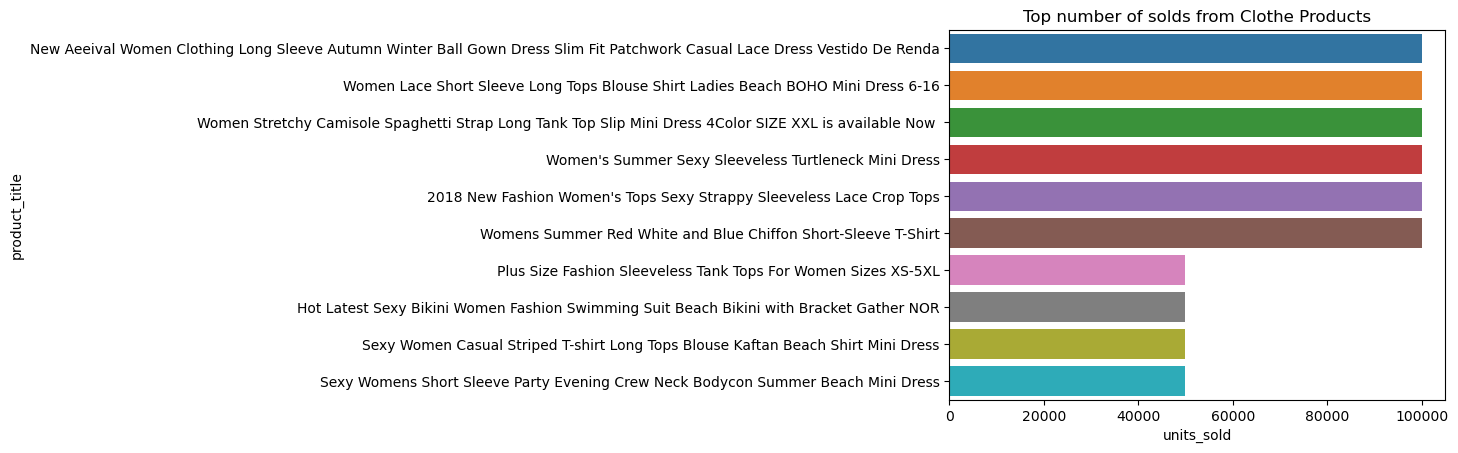

,product_category,units_sold
1,Dress,2781782
6,Shirts,1927436
10,Swim and Beach Wear,691083
11,Vest,675390
5,Pants,559341
2,Foot Wear,62200
4,Others,37900
7,Skirts,35120
9,Sports Wear,21655
3,Head Cover,10240


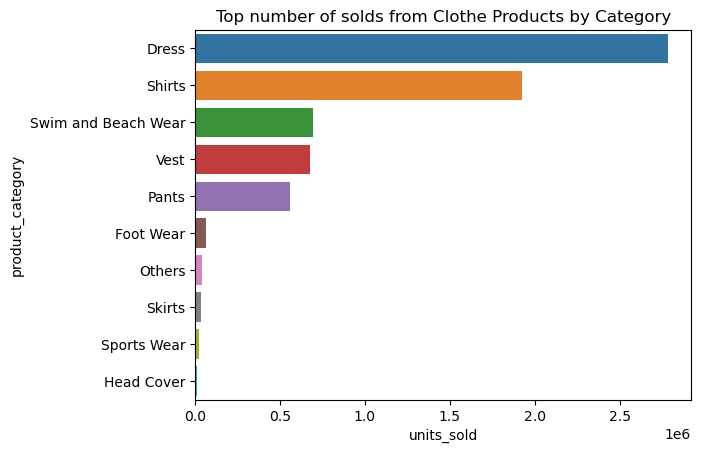

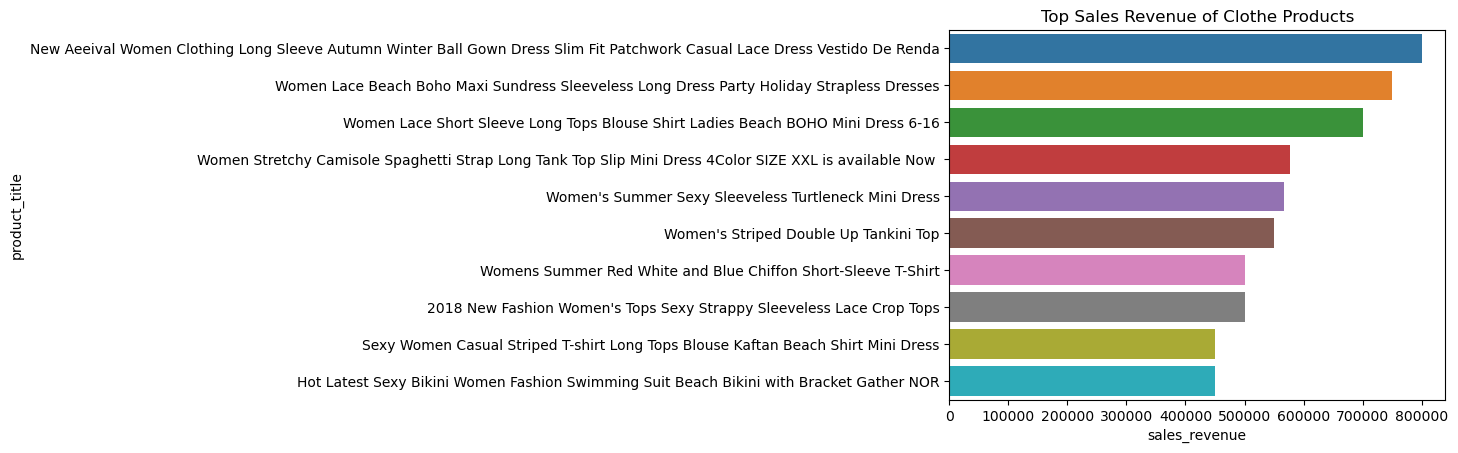

,product_category,sales_revenue
1,Dress,25074926.42
6,Shirts,13677636.00
10,Swim and Beach Wear,5823220.00
5,Pants,5008739.60
11,Vest,4233424.50
4,Others,497237.00
2,Foot Wear,351259.00
7,Skirts,301500.00
9,Sports Wear,139198.43
3,Head Cover,47781.20


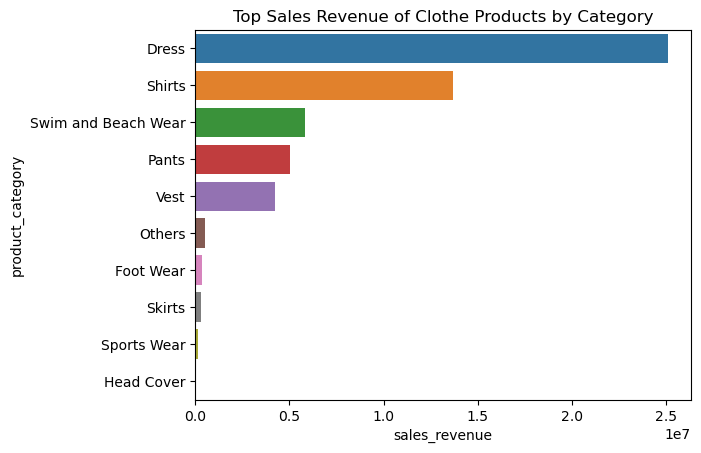

In [388]:
display(sumclo_df[['product_title','product_category','units_sold','sales_revenue']])
sns.barplot(x='units_sold', y='product_title', data=sumclo_df.sort_values(by='units_sold', ascending=False).head(10))
plt.title('Top number of solds from Clothe Products')
plt.show()

display(sumclo_df.groupby('product_category')['units_sold'].sum().reset_index().sort_values(by='units_sold', ascending=False).head(10))
sns.barplot(x='units_sold', y='product_category', data=sumclo_df.groupby('product_category')['units_sold'].sum().reset_index().sort_values(
                                                                    by='units_sold', ascending=False).head(10))
plt.title('Top number of solds from Clothe Products by Category')
plt.show()

sns.barplot(x='sales_revenue', y='product_title', data=sumclo_df.sort_values(by='sales_revenue', ascending=False).head(10))
plt.title('Top Sales Revenue of Clothe Products')
plt.show()

display(sumclo_df.groupby('product_category')['sales_revenue'].sum().reset_index().sort_values(by='sales_revenue', ascending=False).head(10))

sns.barplot(x='sales_revenue', y='product_category', data=sumclo_df.groupby('product_category')['sales_revenue'].sum().reset_index().sort_values(
    by='sales_revenue', ascending=False).head(10))
plt.title('Top Sales Revenue of Clothe Products by Category')
plt.show()

How many good perform of local product (badges local = 1), sort by rating count five

In [55]:
print(sumclo_df['badge_local_product'].value_counts(),'\n')
print(sumclo_df['badge_product_quality'].value_counts(),'\n')
print(sumclo_df['badge_fast_shipping'].value_counts())

0    1510
1      29
Name: badge_local_product, dtype: int64 

0    1425
1     114
Name: badge_product_quality, dtype: int64 

0    1519
1      20
Name: badge_fast_shipping, dtype: int64


In [333]:
sumclo_df[sumclo_df['badge_product_quality'] == 1][['product_title','rating','rating_five_count','rating_four_count','rating_three_count',
                                                  'rating_two_count','rating_one_count']].sort_values(by='rating', ascending=False).head(20)

,product_title,rating,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count
1507,50 Pcs Cute Summer Waterproof Stickers Yellow ...,4.64,293.0,52.0,19.0,6.0,7.0
856,Vintage Women Hair Scrunchies Scarf Bowknot So...,4.63,27.0,5.0,2.0,0.0,1.0
1016,Tie Dyed Double Waist Cashew Flower Square Sca...,4.58,26.0,4.0,0.0,2.0,1.0
636,UR SUGAR 4 Bottles/Set Colorful Summer Color G...,4.57,16.0,4.0,3.0,0.0,0.0
853,Bali Island Hand-Woven Rattan Bag Straw Purse ...,4.52,394.0,97.0,33.0,9.0,19.0
798,Summer Fashion Dabbing Pug T-Shirt Newest Men ...,4.52,216.0,64.0,16.0,9.0,7.0
1073,2020 Summer & Winter Carp Fishing 3D Over Prin...,4.52,77.0,16.0,7.0,3.0,3.0
908,5 Color Large Size Camouflage Dress Women's Fa...,4.50,82.0,17.0,7.0,3.0,4.0
265,5 Color Large Size Camouflage Dress Women's Fa...,4.50,82.0,17.0,7.0,3.0,4.0
1497,Fashion Ocean Wave Silver & Rose Gold Ring Sum...,4.48,4130.0,994.0,409.0,148.0,201.0


In [223]:
sumclo_df[sumclo_df['badge_product_quality'] == 0][['product_title','rating','rating_five_count','rating_four_count','rating_three_count',
                                                  'rating_two_count','rating_one_count']].sort_values(by='rating', ascending=False).head(20)

,product_title,rating,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count
746,Women's Summer Fashion Spaghetti Strap Floral ...,5.0,0.0,0.0,0.0,0.0,0.0
112,Womens Summer Fashion Lip Print 2pc Set Ladies...,5.0,0.0,0.0,0.0,0.0,0.0
774,Personal Fan USB Rechargeable Hands Free Neckb...,5.0,0.0,0.0,0.0,0.0,0.0
1190,Women's Summer Slim-fit Print Strapless Sleeve...,5.0,0.0,0.0,0.0,0.0,0.0
904,New Ladies Fashion Print Top Summer V-neck Sle...,5.0,0.0,0.0,0.0,0.0,0.0
248,Summer Fashion Tie-Dye Short Sleeve Long Dress...,5.0,0.0,0.0,0.0,0.0,0.0
438,Women Off Shoulder Floral Print Boho Dress Wom...,5.0,0.0,0.0,0.0,0.0,0.0
1403,Summer New Women Casual Sleeveless Jumpsuits ...,5.0,2.0,0.0,0.0,0.0,0.0
1186,Women Fashion Vintage Animal Dragonfly Owl Pri...,5.0,0.0,0.0,0.0,0.0,0.0
1172,New Women Fashion Shorts Yoga Shorts Summer Be...,5.0,1.0,0.0,0.0,0.0,0.0


In [199]:
sumclo_df[sumclo_df['badge_local_product'] == 1][['product_title','rating','rating_five_count','rating_four_count','rating_three_count',
                                                  'rating_two_count','rating_one_count']].sort_values(by='rating', ascending=False)

,product_title,rating,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count
475,Men Summer Running Shorts 2 in 1 Sports Joggin...,4.62,27.0,4.0,1.0,1.0,1.0
675,NEW Fashion Women Flower Slip On Platform Sand...,4.53,32.0,6.0,3.0,0.0,2.0
853,Bali Island Hand-Woven Rattan Bag Straw Purse ...,4.52,394.0,97.0,33.0,9.0,19.0
1020,Summer Steering Wheel Sunshade Swim Ring Car I...,4.40,2541.0,673.0,309.0,73.0,191.0
1061,Sexy Women Camouflage Print Bandage Push-up Sw...,4.29,1789.0,459.0,300.0,110.0,150.0
1255,Summer New Fashion Women Ice Silk Sleepwear Se...,4.24,120.0,32.0,19.0,9.0,12.0
1402,Women Sexy Halter Cowl Neck Backless Ruched Ta...,4.16,975.0,406.0,210.0,94.0,95.0
99,Men Cotton Overalls Camouflage Loose Shorts El...,4.11,17.0,4.0,3.0,1.0,3.0
1219,Summer New Fashion Women Two Pieces Sleepwear ...,4.10,238.0,75.0,43.0,19.0,38.0
493,Boho Vintage Women Floral Printed Long Dress S...,4.10,212.0,61.0,38.0,20.0,33.0


In [206]:
sumclo_df[sumclo_df['badge_local_product'] == 1][['product_title','units_sold','rating','rating_five_count','rating_four_count','rating_three_count',
                                                  'rating_two_count','rating_one_count']].sort_values(by='rating', ascending=False)

,product_title,units_sold,rating,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count
475,Men Summer Running Shorts 2 in 1 Sports Joggin...,100,4.62,27.0,4.0,1.0,1.0,1.0
675,NEW Fashion Women Flower Slip On Platform Sand...,100,4.53,32.0,6.0,3.0,0.0,2.0
853,Bali Island Hand-Woven Rattan Bag Straw Purse ...,1000,4.52,394.0,97.0,33.0,9.0,19.0
1020,Summer Steering Wheel Sunshade Swim Ring Car I...,20000,4.40,2541.0,673.0,309.0,73.0,191.0
1061,Sexy Women Camouflage Print Bandage Push-up Sw...,10000,4.29,1789.0,459.0,300.0,110.0,150.0
1255,Summer New Fashion Women Ice Silk Sleepwear Se...,1000,4.24,120.0,32.0,19.0,9.0,12.0
1402,Women Sexy Halter Cowl Neck Backless Ruched Ta...,10000,4.16,975.0,406.0,210.0,94.0,95.0
99,Men Cotton Overalls Camouflage Loose Shorts El...,100,4.11,17.0,4.0,3.0,1.0,3.0
1219,Summer New Fashion Women Two Pieces Sleepwear ...,1000,4.10,238.0,75.0,43.0,19.0,38.0
493,Boho Vintage Women Floral Printed Long Dress S...,1000,4.10,212.0,61.0,38.0,20.0,33.0


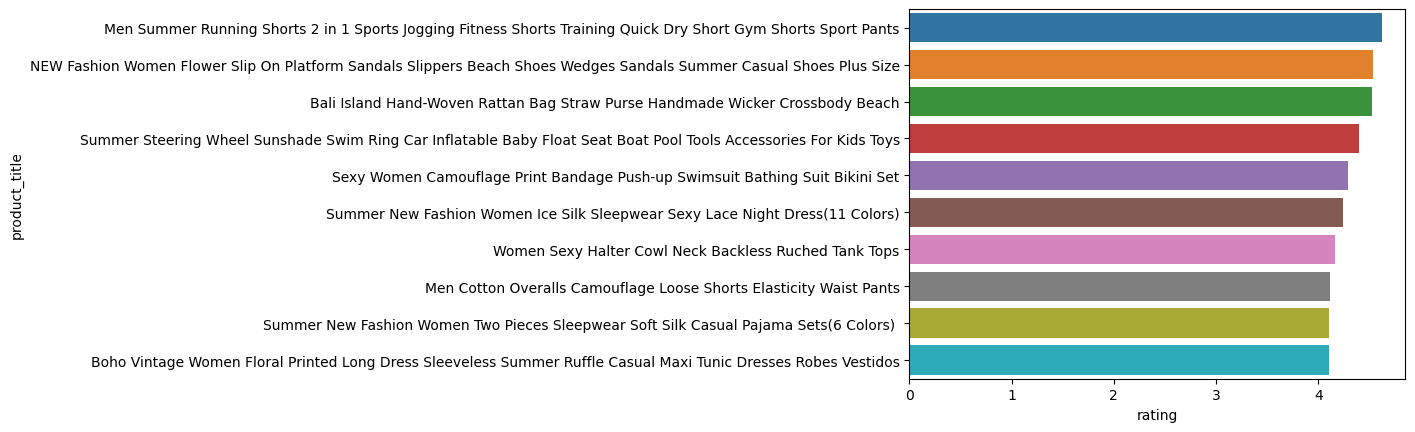

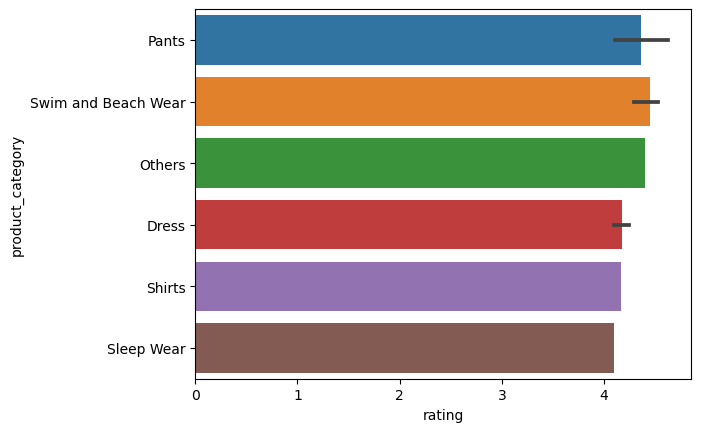

In [353]:
sns.barplot(x='rating',y='product_title',data=sumclo_df[sumclo_df['badge_local_product'] == 1][['product_title','rating','rating_five_count',
            'rating_four_count', 'rating_three_count','rating_two_count','rating_one_count']].sort_values(by='rating', ascending=False).head(10))
plt.show()

sns.barplot(x='rating',y='product_category',data=sumclo_df[sumclo_df['badge_local_product'] == 1][['product_category','rating','rating_five_count',
            'rating_four_count', 'rating_three_count','rating_two_count','rating_one_count']].sort_values(by='rating', ascending=False).head(10))
plt.show()

In [229]:
sumclo_df['badge_local_product'].value_counts()

0    1510
1      29
Name: badge_local_product, dtype: int64

C:\Users\Hendry\AppData\Local\Temp\ipykernel_8564\1133545982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_product_compare['local_product'] = local_product_compare['badge_local_product'].replace({0:'Import', 1:'Local'})


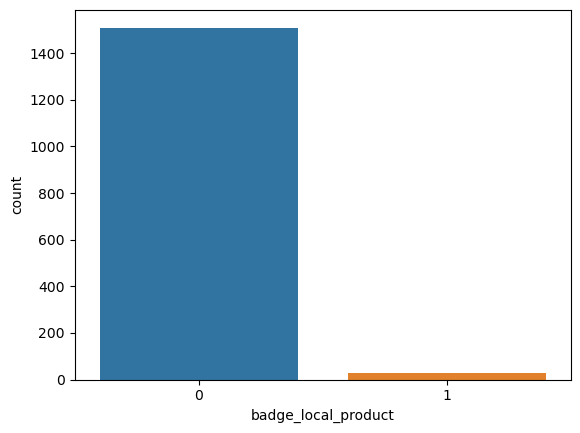

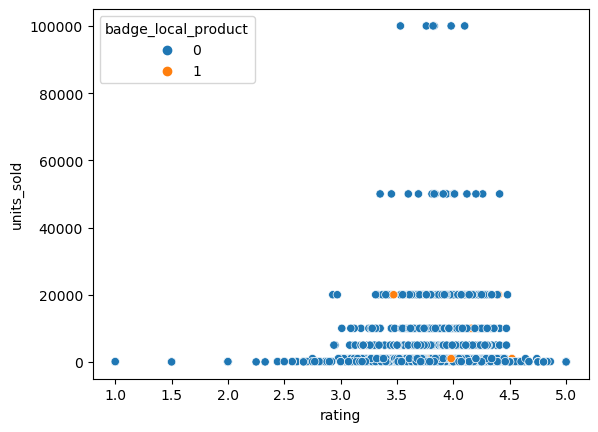

In [242]:
local_product_compare = sumclo_df[['product_title','product_category','badge_local_product','units_sold','rating']]
local_product_compare['local_product'] = local_product_compare['badge_local_product'].replace({0:'Import', 1:'Local'})

sns.countplot(x='badge_local_product', data=local_product_compare)
plt.show()

sns.scatterplot(x='rating',y='units_sold', hue='badge_local_product', data=local_product_compare)
plt.show()

How many sales use ads (uses_ads_boosts = 1) to increase products, sort by product solds

In [56]:
sumclo_df['uses_ad_boosts'].value_counts()

0    868
1    671
Name: uses_ad_boosts, dtype: int64

C:\Users\Hendry\AppData\Local\Temp\ipykernel_8564\3300466937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sold_with_ads['boosted_ad'] = sold_with_ads['uses_ad_boosts'].replace({0:'No Ads', 1:'Using Ads'})


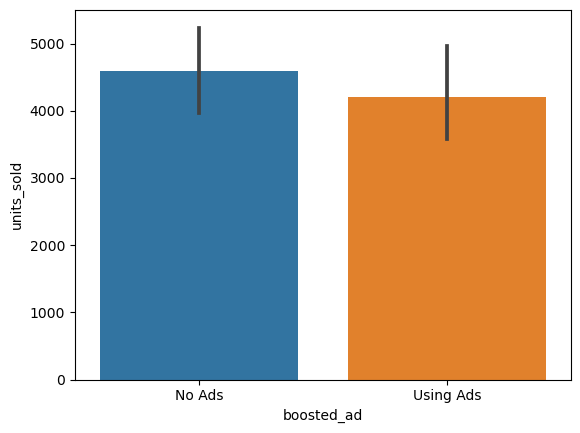

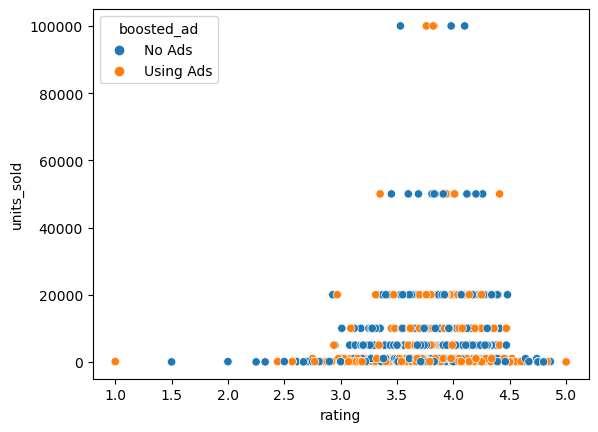

In [241]:
sold_with_ads = sumclo_df[['product_title','product_category','units_sold','uses_ad_boosts','rating']]
sold_with_ads['boosted_ad'] = sold_with_ads['uses_ad_boosts'].replace({0:'No Ads', 1:'Using Ads'})
# sold_with_ads['boosted_ad']
sns.barplot(y='units_sold',x='boosted_ad',data=sold_with_ads)
plt.show()

sns.scatterplot(x='rating',y='units_sold', hue='boosted_ad', data=sold_with_ads)
plt.show()

How many sales revenue with using ads (uses_ads_boosts = 1) to increase products, sort by product solds

C:\Users\Hendry\AppData\Local\Temp\ipykernel_8564\1699603909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sold_with_ads['boosted_ad'] = sold_with_ads['uses_ad_boosts'].replace({0:'No Ads', 1:'Using Ads'})


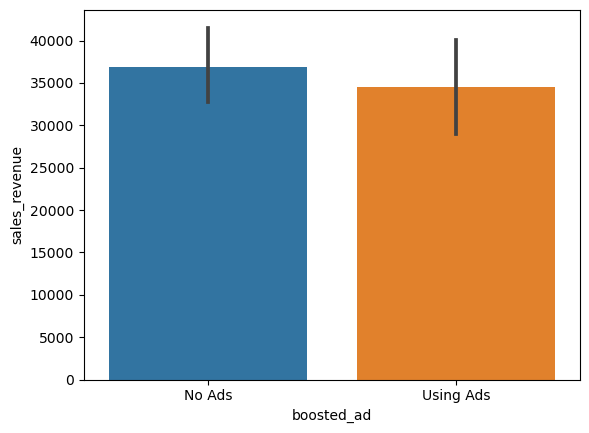

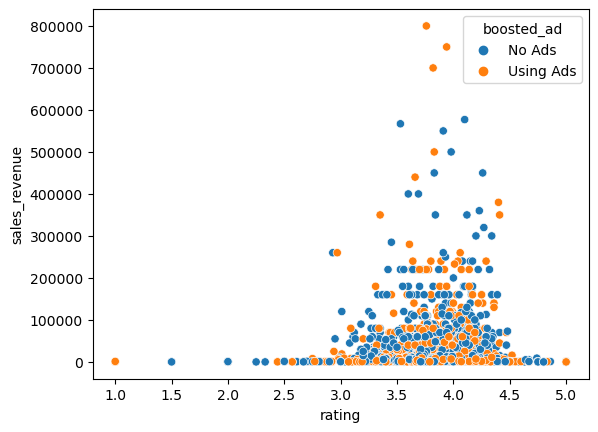

In [334]:
sold_with_ads = sumclo_df[['product_title','product_category','sales_revenue','uses_ad_boosts','rating']]
sold_with_ads['boosted_ad'] = sold_with_ads['uses_ad_boosts'].replace({0:'No Ads', 1:'Using Ads'})
# sold_with_ads['boosted_ad']
sns.barplot(y='sales_revenue',x='boosted_ad',data=sold_with_ads)
plt.show()

sns.scatterplot(x='rating',y='sales_revenue', hue='boosted_ad', data=sold_with_ads)
plt.show()

What is the top Favorite products by Rating 5 and Rating 4

In [245]:
sumclo_df[['product_title','units_sold','rating','rating_five_count','rating_four_count']].sort_values(by='rating_five_count', ascending=False)

,product_title,units_sold,rating,rating_five_count,rating_four_count
84,2018 Summer Fashion Women Tank Tops Sexy Women...,50000,4.41,11548.0,3191.0
92,Women Stretchy Camisole Spaghetti Strap Long T...,100000,4.10,11184.0,4152.0
17,2018 New Fashion Women's Tops Sexy Strappy Sle...,100000,3.83,8290.0,3483.0
1466,Summer Women Sexy White Embroidery Lace Crop T...,50000,3.60,7530.0,3351.0
957,Sexy Womens Short Sleeve Party Evening Crew Ne...,50000,4.20,7337.0,2647.0
...,...,...,...,...,...
438,Women Off Shoulder Floral Print Boho Dress Wom...,100,5.00,0.0,0.0
1292,Women Fashion Leopard Lips Crewneck Tee Short ...,6,5.00,0.0,0.0
122,Summer fashion female butterfly tank vest slee...,50,3.00,0.0,1.0
126,Women's Casual Sleeveless Stripe T Shirts Dres...,1,5.00,0.0,0.0


c:\Users\Hendry\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


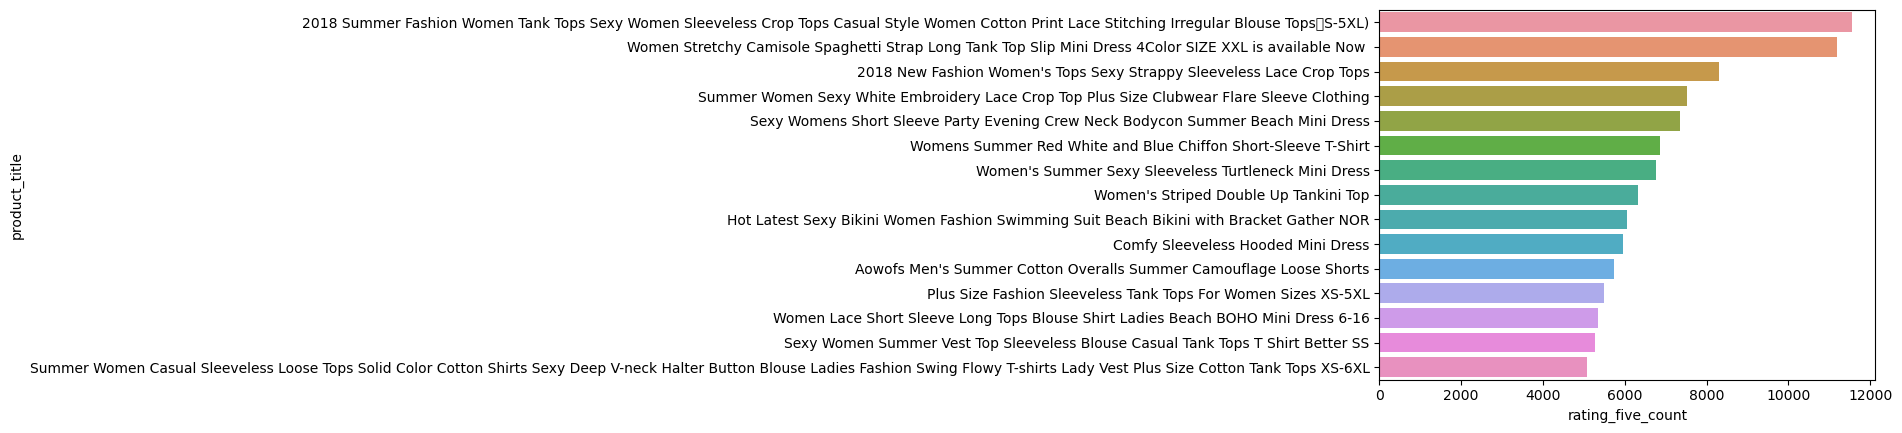

In [250]:
sns.barplot(x='rating_five_count',y='product_title', data=sumclo_df.sort_values(by='rating_five_count', ascending=False).head(15))
plt.show()

What is the top Favorite products with Sizes by Rating 5 and Rating 4

In [335]:
sumclo_df[['product_title','product_variation_size_id','units_sold','sales_revenue','rating','rating_five_count','rating_four_count']
          ].sort_values(by='rating_five_count', ascending=False)

,product_title,product_variation_size_id,units_sold,sales_revenue,rating,rating_five_count,rating_four_count
84,2018 Summer Fashion Women Tank Tops Sexy Women...,M,50000,350000.00,4.41,11548.0,3191.0
92,Women Stretchy Camisole Spaghetti Strap Long T...,XS,100000,577000.00,4.10,11184.0,4152.0
17,2018 New Fashion Women's Tops Sexy Strappy Sle...,S,100000,500000.00,3.83,8290.0,3483.0
1466,Summer Women Sexy White Embroidery Lace Crop T...,S,50000,400000.00,3.60,7530.0,3351.0
957,Sexy Womens Short Sleeve Party Evening Crew Ne...,S,50000,300000.00,4.20,7337.0,2647.0
...,...,...,...,...,...,...,...
438,Women Off Shoulder Floral Print Boho Dress Wom...,XS,100,700.00,5.00,0.0,0.0
1292,Women Fashion Leopard Lips Crewneck Tee Short ...,XS,6,36.00,5.00,0.0,0.0
122,Summer fashion female butterfly tank vest slee...,S,50,350.00,3.00,0.0,1.0
126,Women's Casual Sleeveless Stripe T Shirts Dres...,XS,1,2.72,5.00,0.0,0.0


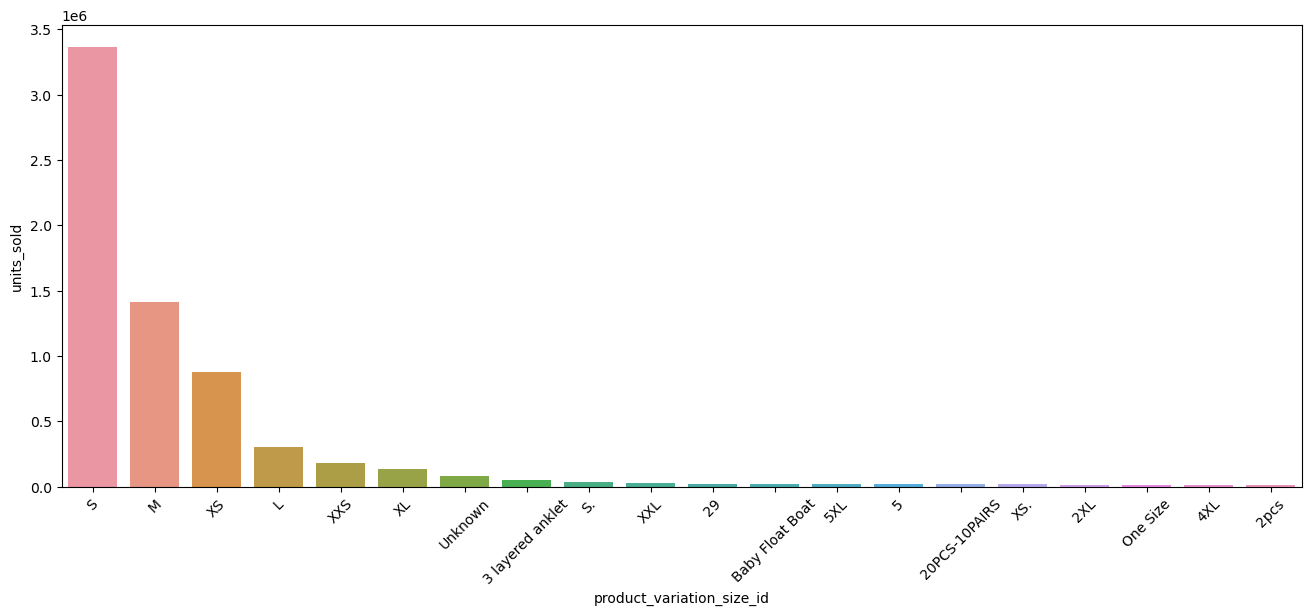

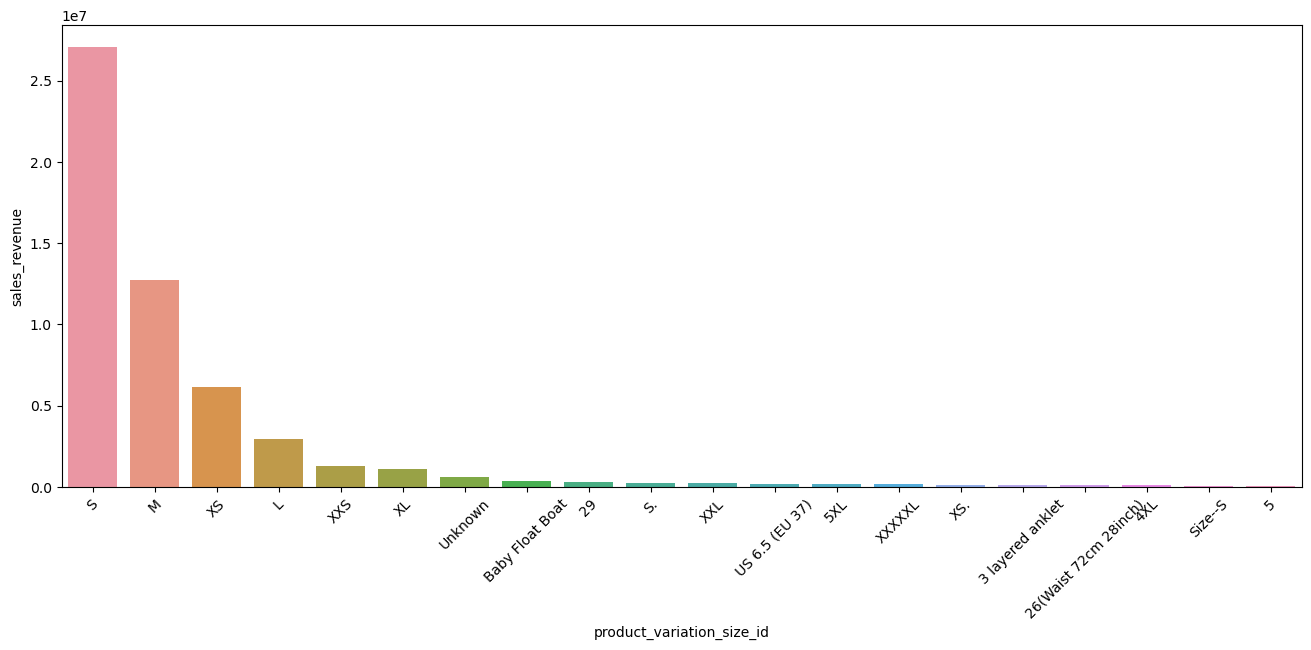

In [336]:
plt.figure(figsize=(16,6))
sns.barplot(data=sumclo_df.groupby('product_variation_size_id')['units_sold'].sum().reset_index().sort_values(by='units_sold', 
        ascending=False).head(20), x='product_variation_size_id', y='units_sold')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(16,6))
sns.barplot(data=sumclo_df.groupby('product_variation_size_id')['sales_revenue'].sum().reset_index().sort_values(by='sales_revenue', 
        ascending=False).head(20), x='product_variation_size_id', y='sales_revenue')
plt.xticks(rotation=45)
plt.show()

c:\Users\Hendry\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


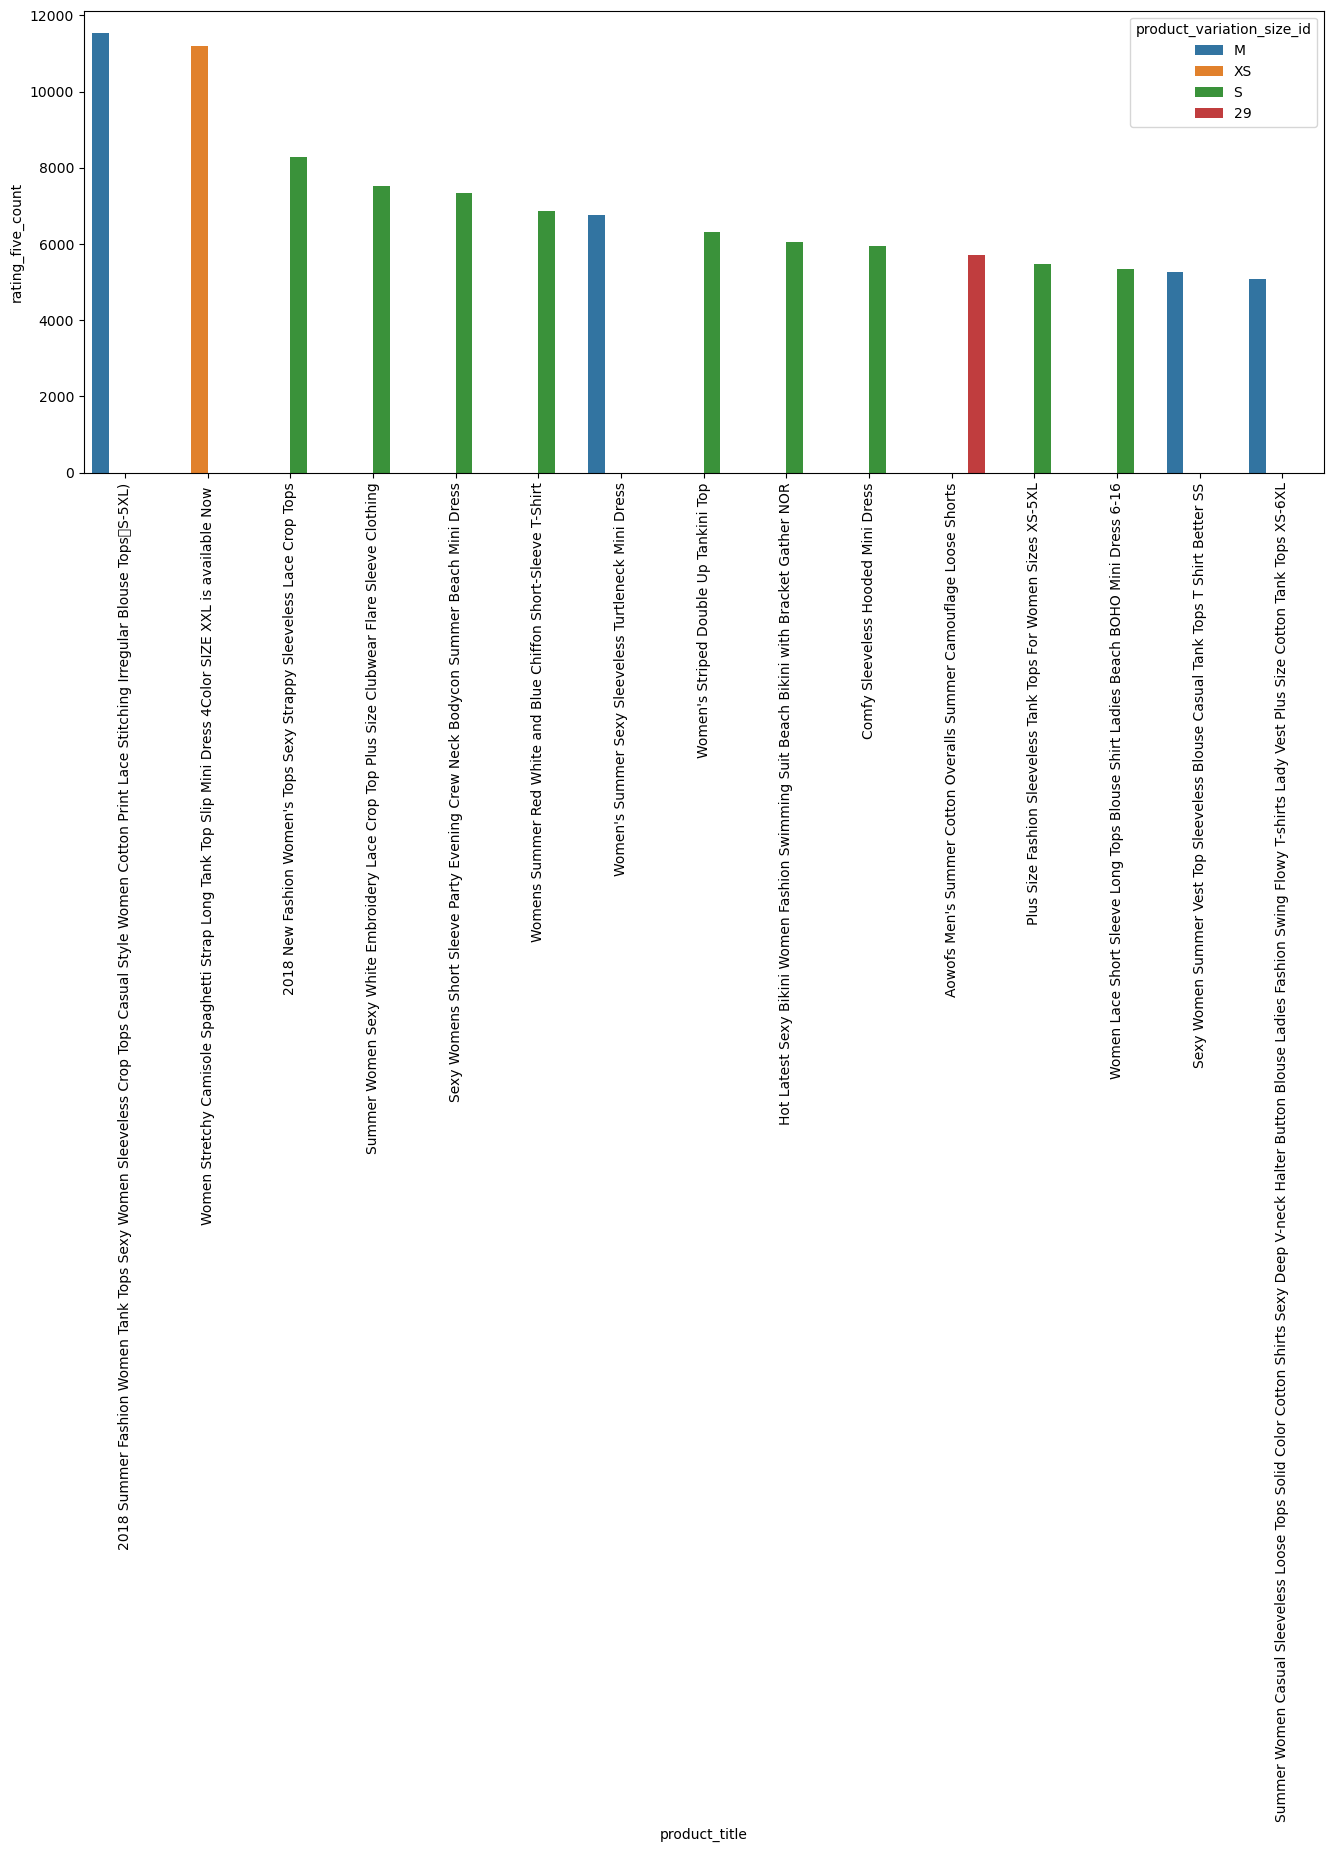

In [277]:
plt.figure(figsize=(16,6))
sns.barplot(x='product_title',y='rating_five_count', hue='product_variation_size_id',
            data=sumclo_df.sort_values(by='rating_five_count', ascending=False).head(15))
plt.xticks(rotation=90)
plt.show()

What is the top Favorite products with Colors by Rating 5 and Rating 4

In [337]:
sumclo_df[['product_title','product_color','units_sold','sales_revenue','rating','rating_five_count','rating_four_count']
          ].sort_values(by='rating_five_count', ascending=False)

,product_title,product_color,units_sold,sales_revenue,rating,rating_five_count,rating_four_count
84,2018 Summer Fashion Women Tank Tops Sexy Women...,green,50000,350000.00,4.41,11548.0,3191.0
92,Women Stretchy Camisole Spaghetti Strap Long T...,black,100000,577000.00,4.10,11184.0,4152.0
17,2018 New Fashion Women's Tops Sexy Strappy Sle...,white,100000,500000.00,3.83,8290.0,3483.0
1466,Summer Women Sexy White Embroidery Lace Crop T...,Unknown,50000,400000.00,3.60,7530.0,3351.0
957,Sexy Womens Short Sleeve Party Evening Crew Ne...,black,50000,300000.00,4.20,7337.0,2647.0
...,...,...,...,...,...,...,...
438,Women Off Shoulder Floral Print Boho Dress Wom...,tan,100,700.00,5.00,0.0,0.0
1292,Women Fashion Leopard Lips Crewneck Tee Short ...,white,6,36.00,5.00,0.0,0.0
122,Summer fashion female butterfly tank vest slee...,blue,50,350.00,3.00,0.0,1.0
126,Women's Casual Sleeveless Stripe T Shirts Dres...,orange,1,2.72,5.00,0.0,0.0


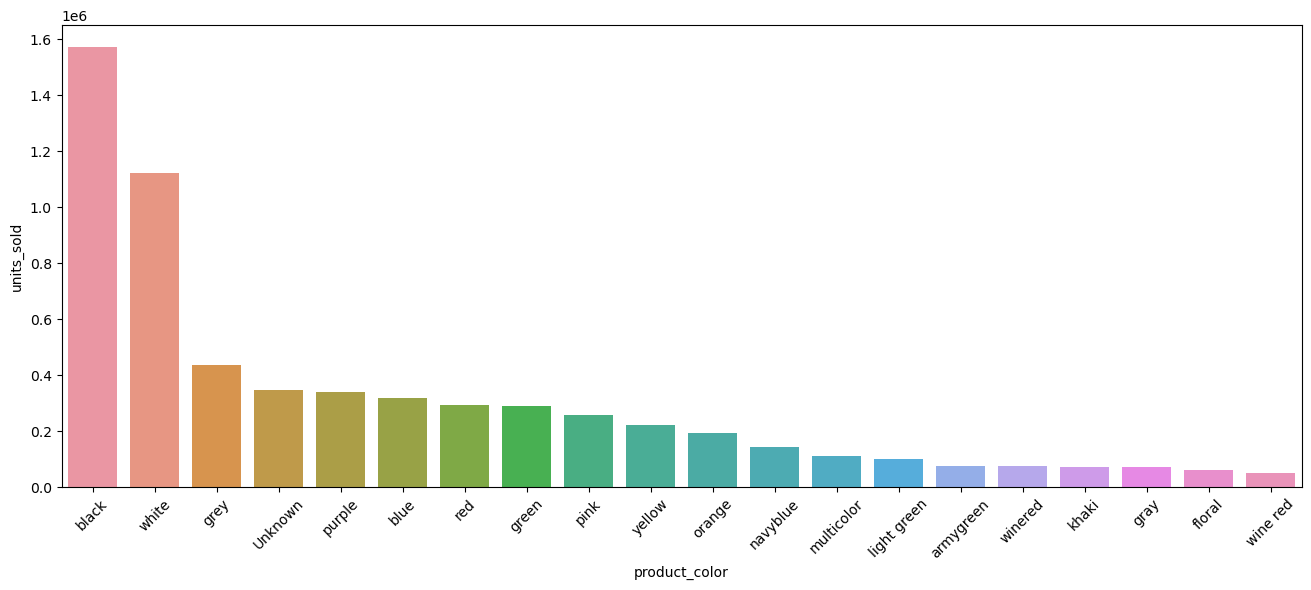

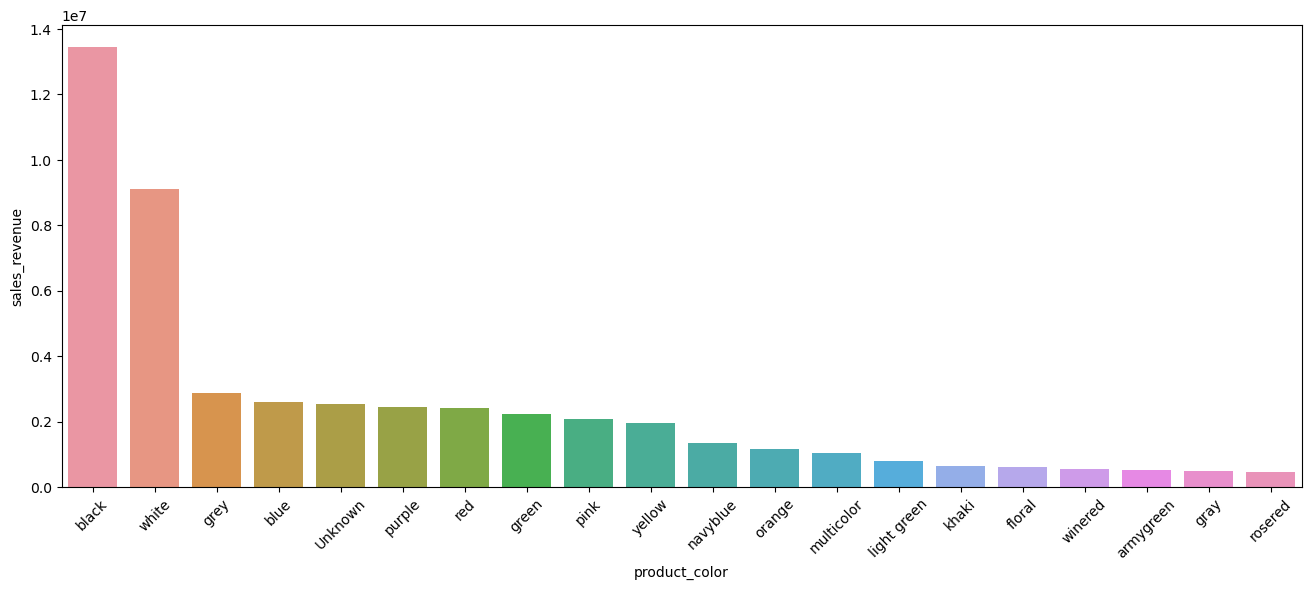

In [338]:
plt.figure(figsize=(16,6))
sns.barplot(data=sumclo_df.groupby('product_color')['units_sold'].sum().reset_index().sort_values(by='units_sold', 
        ascending=False).head(20), x='product_color', y='units_sold')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(16,6))
sns.barplot(data=sumclo_df.groupby('product_color')['sales_revenue'].sum().reset_index().sort_values(by='sales_revenue', 
        ascending=False).head(20), x='product_color', y='sales_revenue')
plt.xticks(rotation=45)
plt.show()

c:\Users\Hendry\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


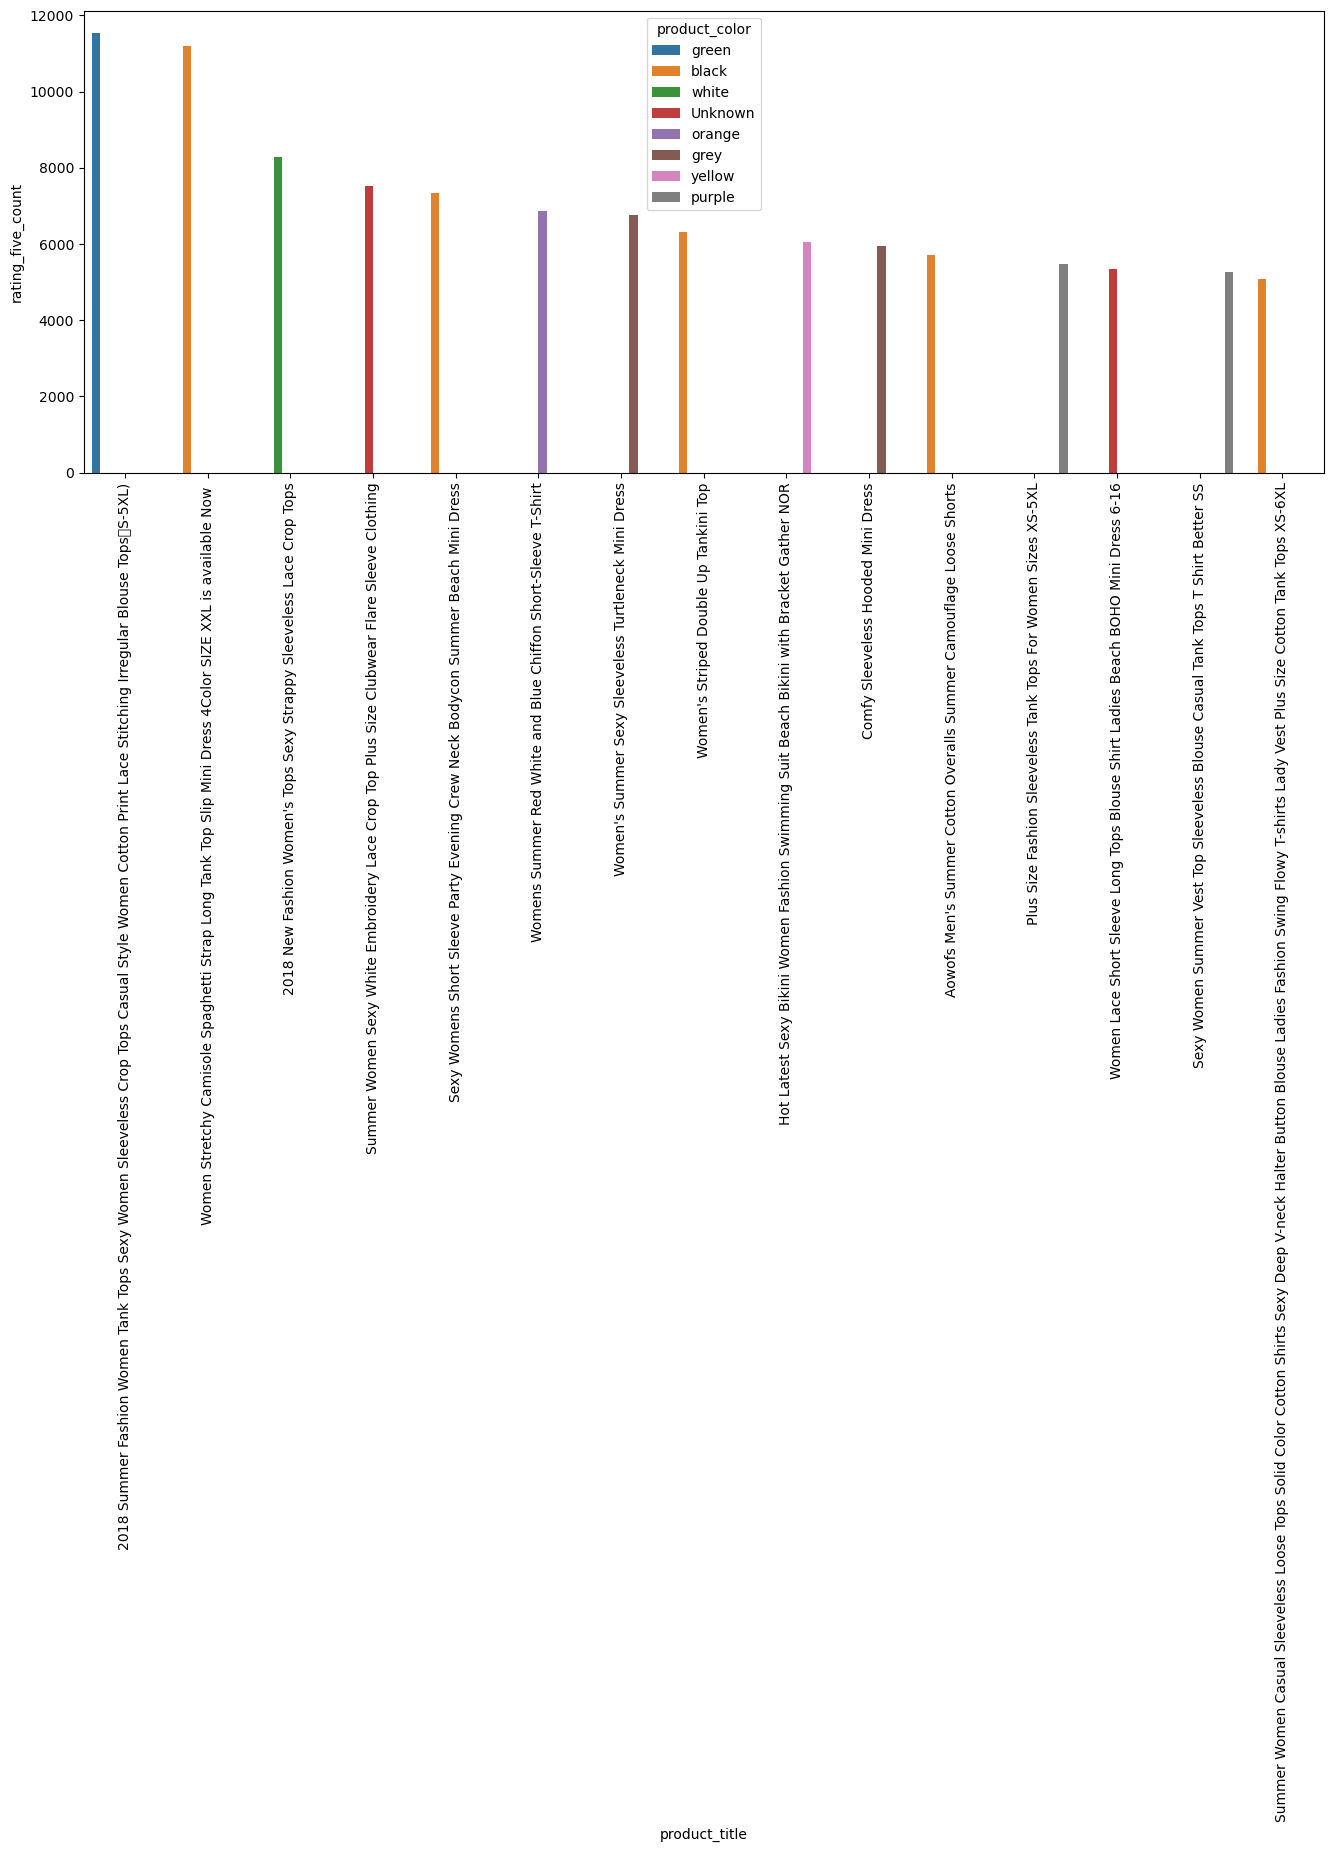

In [276]:
plt.figure(figsize=(16,6))
sns.barplot(x='product_title',y='rating_five_count', hue='product_color',
            data=sumclo_df.sort_values(by='rating_five_count', ascending=False).head(15))
plt.xticks(rotation=90)
plt.show()

What is top Performance Product with Urgency Banner

c:\Users\Hendry\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


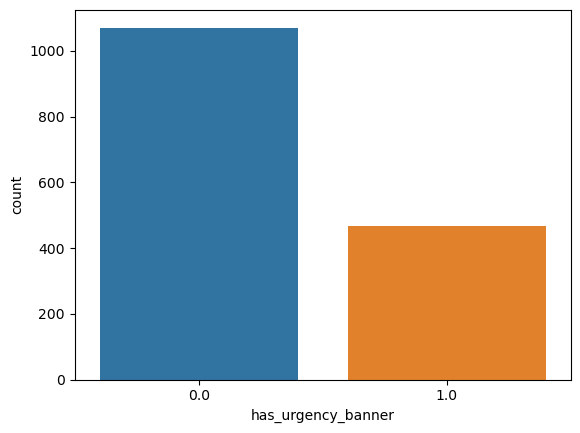

c:\Users\Hendry\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


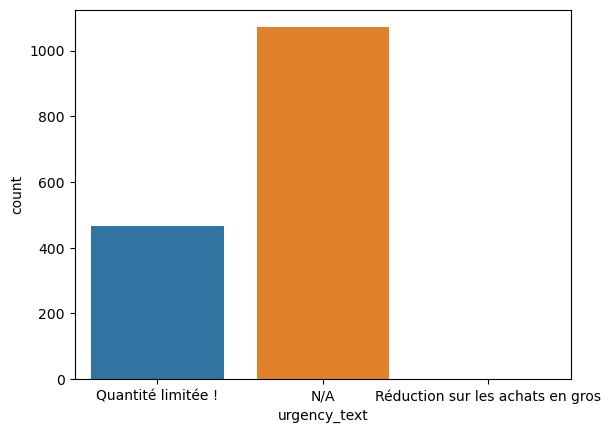

In [303]:
sns.countplot('has_urgency_banner', data=sumclo_df)
plt.show()

sns.countplot('urgency_text', data=sumclo_df)
plt.show()

C:\Users\Hendry\AppData\Local\Temp\ipykernel_8564\2790190157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urgent_product['urgency_status'] = urgent_product['has_urgency_banner'].replace({0:'Not Urgency', 1:'Has Urgency'})


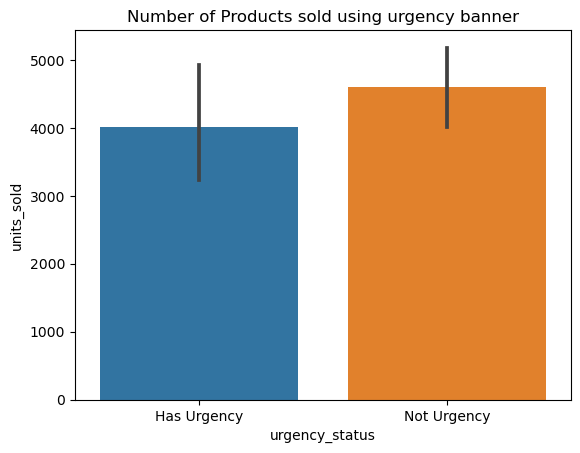

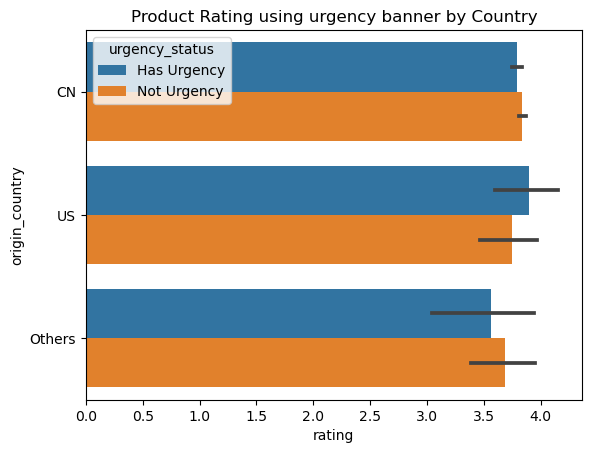

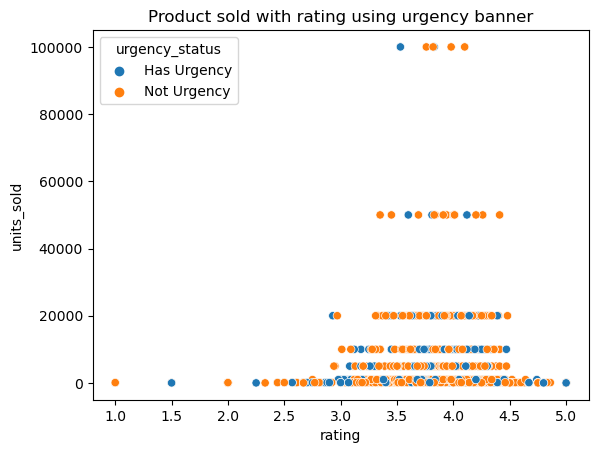

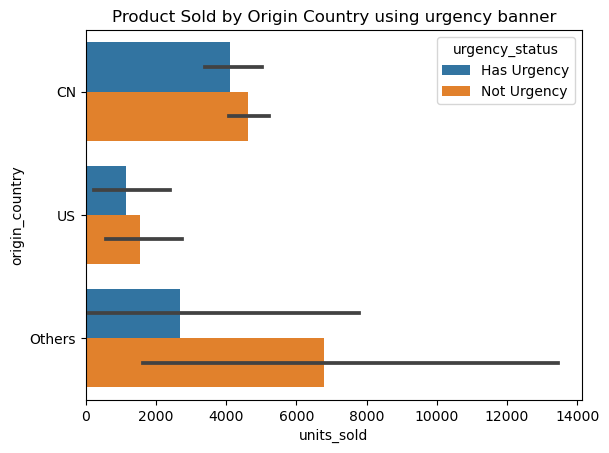

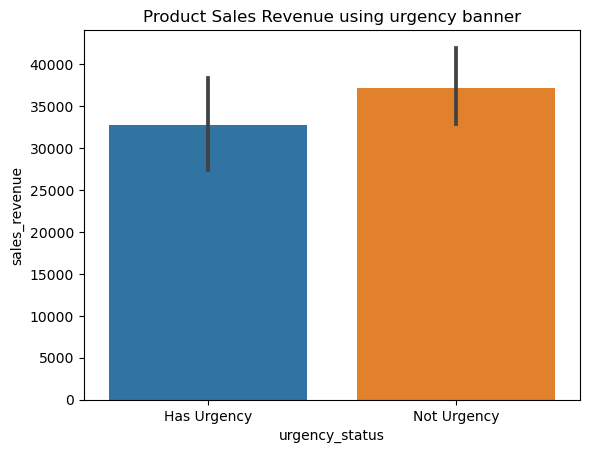

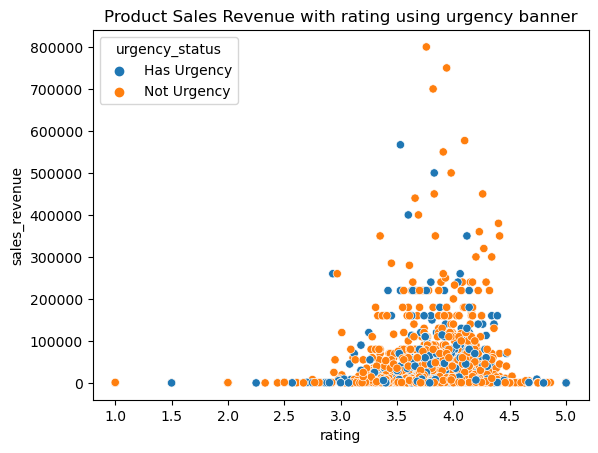

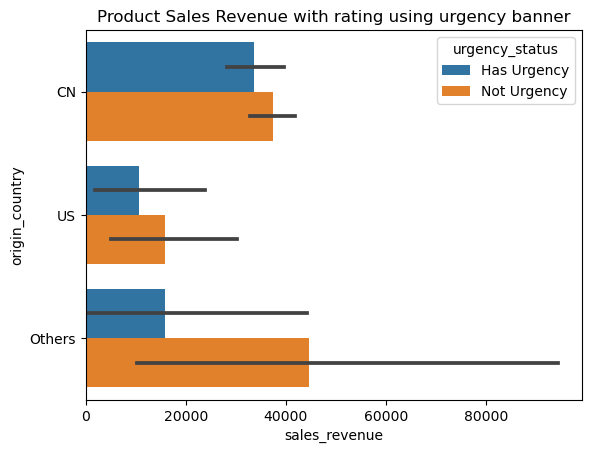

In [340]:
urgent_product = sumclo_df[['product_title','product_category','origin_country','units_sold','sales_revenue','has_urgency_banner','rating']]
urgent_product['urgency_status'] = urgent_product['has_urgency_banner'].replace({0:'Not Urgency', 1:'Has Urgency'})
# urgent_product['urgency_status']
plt.title('Number of Products sold using urgency banner')
sns.barplot(y='units_sold',x='urgency_status',data=urgent_product)
plt.show()

plt.title('Product Rating using urgency banner by Country')
sns.barplot(x='rating',y='origin_country', hue='urgency_status', data=urgent_product)
plt.show()

plt.title('Product sold with rating using urgency banner')
sns.scatterplot(x='rating',y='units_sold', hue='urgency_status', data=urgent_product)
plt.show()

plt.title('Product Sold by Origin Country using urgency banner')
sns.barplot(x='units_sold',y='origin_country', hue='urgency_status', data=urgent_product)
plt.show()

plt.title('Product Sales Revenue using urgency banner')
sns.barplot(y='sales_revenue',x='urgency_status',data=urgent_product)
plt.show()

plt.title('Product Sales Revenue with rating using urgency banner')
sns.scatterplot(x='rating',y='sales_revenue', hue='urgency_status', data=urgent_product)
plt.show()

plt.title('Product Sales Revenue with rating using urgency banner')
sns.barplot(x='sales_revenue',y='origin_country', hue='urgency_status', data=urgent_product)
plt.show()

How much performing of the product on Country with by rating counts

c:\Users\Hendry\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


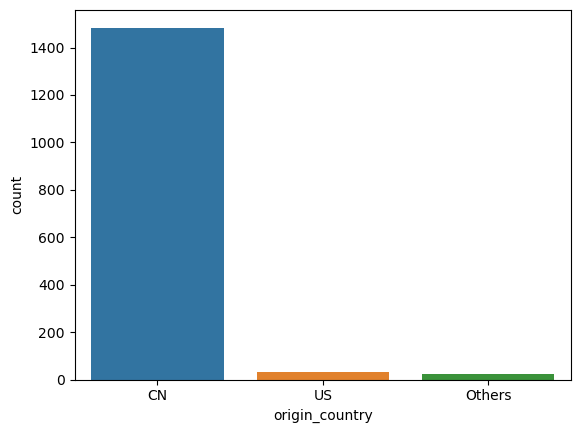

In [281]:
sns.countplot('origin_country', data=sumclo_df)
plt.show()

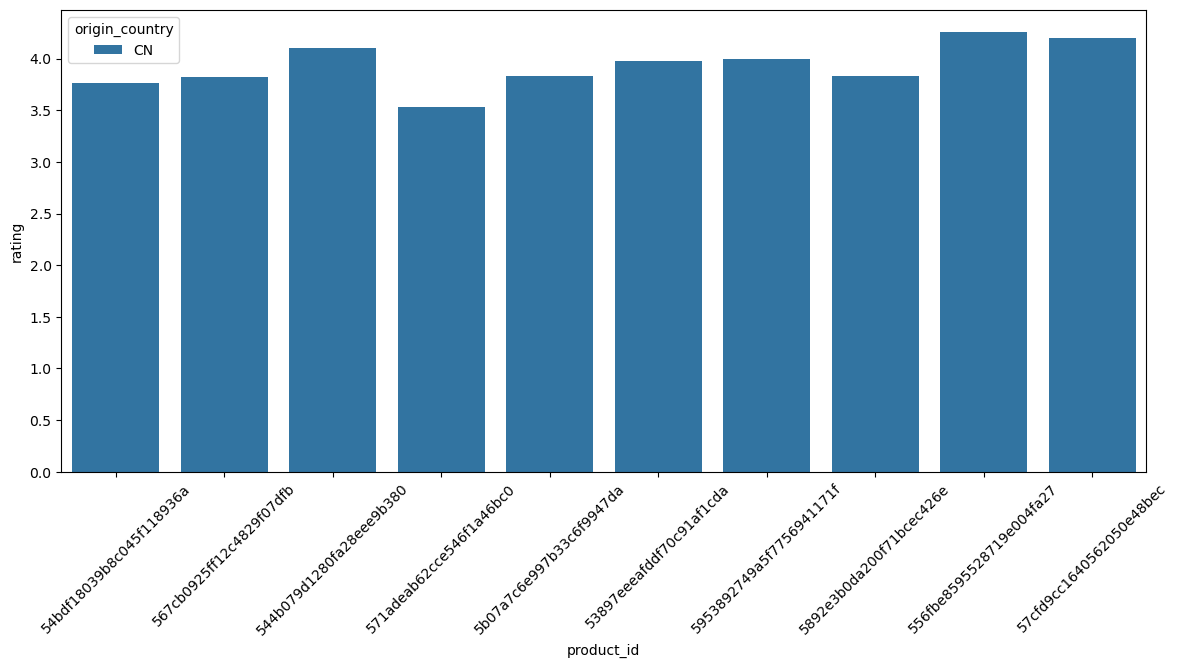

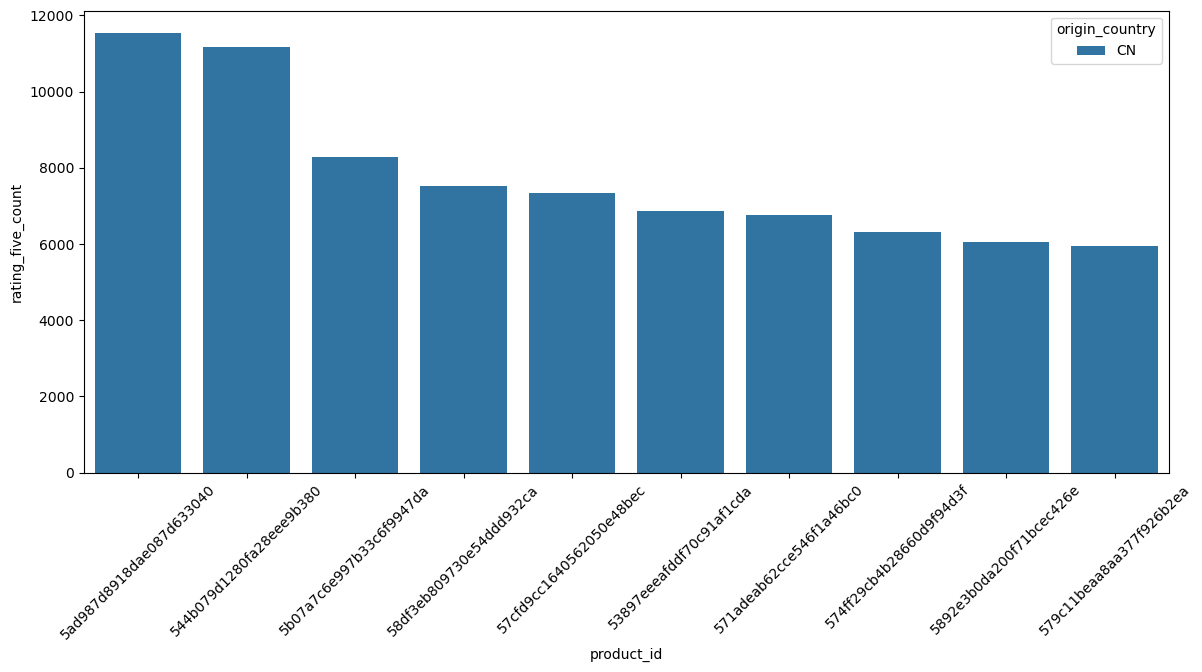

In [300]:
plt.figure(figsize=(14,6))
sns.barplot(x='product_id',hue='origin_country',y='rating', data=sumclo_df.sort_values(by='units_sold',ascending=False).head(10))
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14,6))
sns.barplot(x='product_id',hue='origin_country',y='rating_five_count', data=sumclo_df.sort_values(by='rating_five_count',ascending=False).head(10))
plt.xticks(rotation=45)
plt.show()

How much performing of the product on Country with by rating counts after China

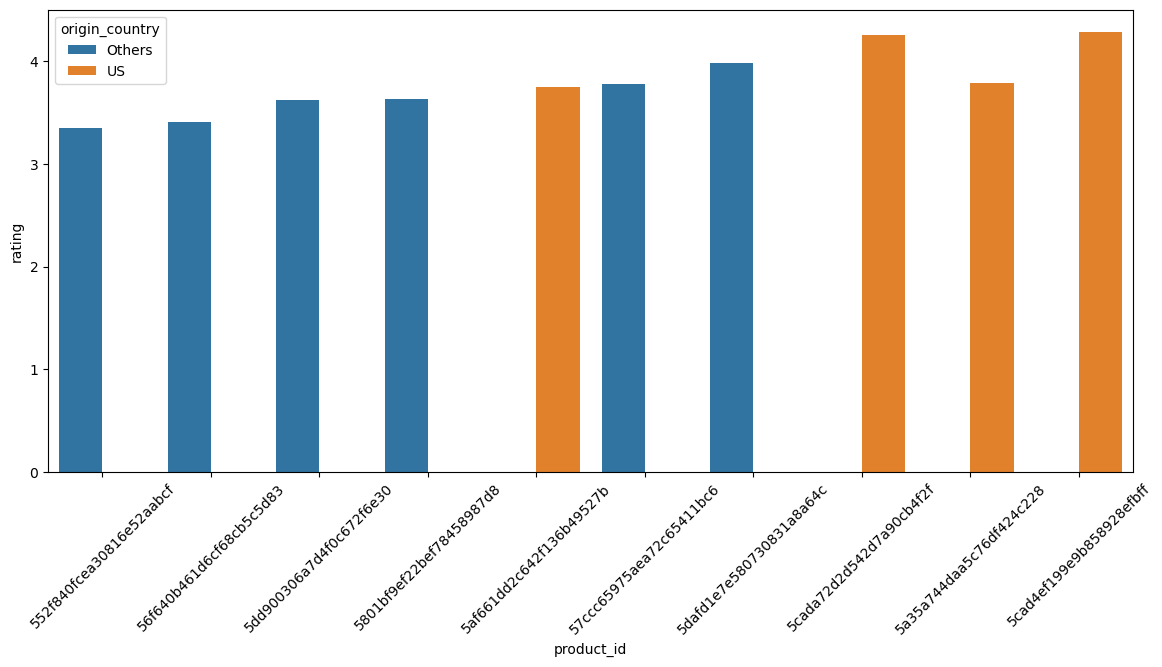

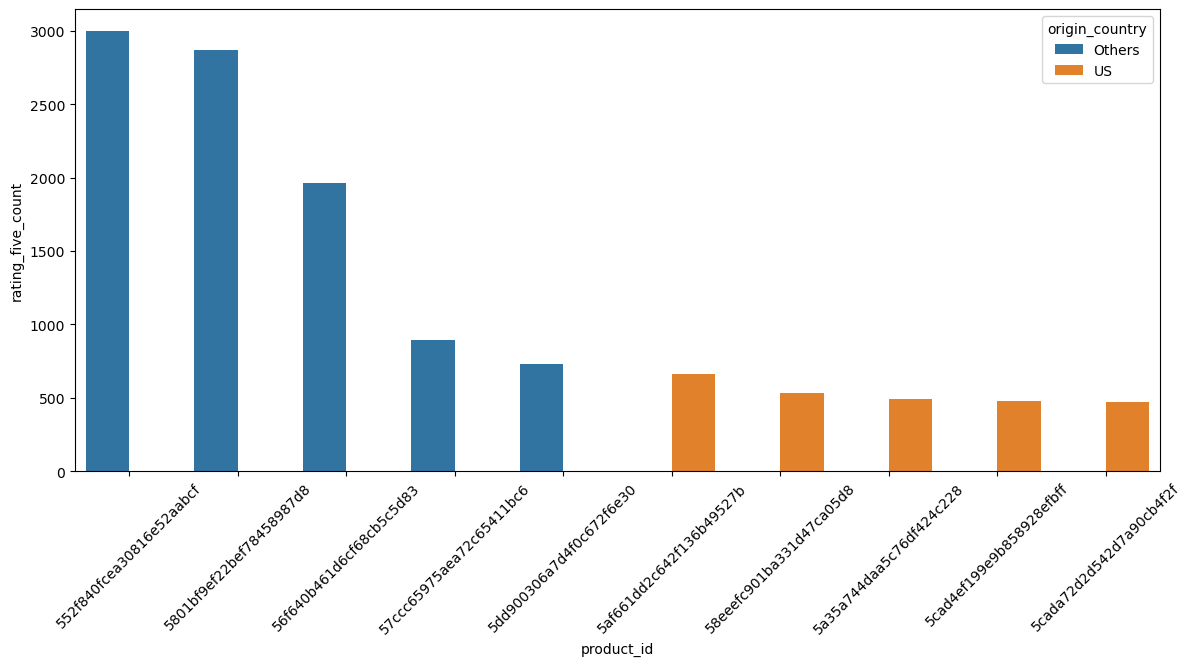

In [301]:
plt.figure(figsize=(14,6))
sns.barplot(x='product_id',hue='origin_country',y='rating', 
            data=sumclo_df[sumclo_df['origin_country']!='CN'].sort_values(by='units_sold',ascending=False).head(10))
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14,6))
sns.barplot(x='product_id',hue='origin_country',y='rating_five_count', 
            data=sumclo_df[sumclo_df['origin_country']!='CN'].sort_values(by='rating_five_count',ascending=False).head(10))
plt.xticks(rotation=45)
plt.show()

How many top rated merchant and its origin Country by merchant ratings

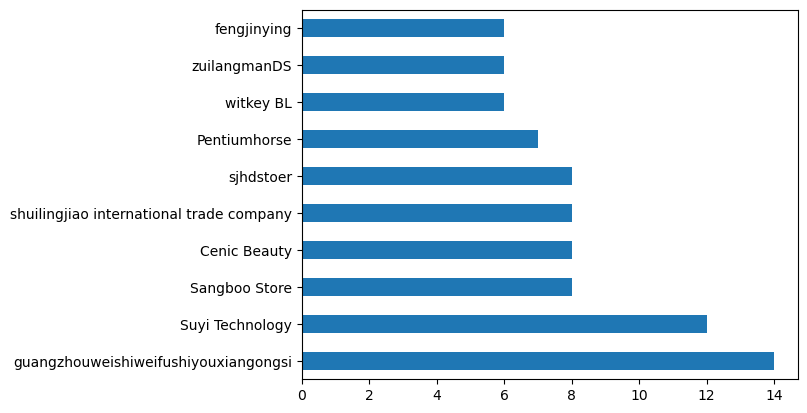

In [294]:
sumclo_df['merchant_title'].value_counts().head(10).plot(kind='barh')
plt.show()

In [341]:
display(sumclo_df[sumclo_df['rating_count']>0][['merchant_title','origin_country','merchant_rating','merchant_rating_count','sales_revenue']
                                       ].sort_values(by='merchant_rating', ascending=False))
display(sumclo_df[sumclo_df['rating_count']>0].groupby(['merchant_title','origin_country'])['merchant_rating','merchant_rating_count','sales_revenue'
                                                            ].mean().reset_index().sort_values(by='merchant_rating', ascending=False))

,merchant_title,origin_country,merchant_rating,merchant_rating_count,sales_revenue
956,"shenzhen dcr technology co.,ltd",CN,4.577519,1032,800.0
945,Unlimited retaliation,CN,4.521866,343,373.0
116,langsengy,CN,4.512500,160,56.8
1195,Beautiful Angel Fashion Store,CN,4.501472,2038,180.0
1473,HAODUOYI China-made quality,CN,4.486631,2805,500.0
...,...,...,...,...,...
1043,lumeizi,CN,3.186047,43,800.0
759,uiuieornt,CN,3.038961,231,500.0
393,truth us trading,US,3.034483,29,1200.0
1430,APLUSWORLD,CN,3.000000,3,1200.0


C:\Users\Hendry\AppData\Local\Temp\ipykernel_8564\4018325273.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  display(sumclo_df[sumclo_df['rating_count']>0].groupby(['merchant_title','origin_country'])['merchant_rating','merchant_rating_count','sales_revenue'


,merchant_title,origin_country,merchant_rating,merchant_rating_count,sales_revenue
735,"shenzhen dcr technology co.,ltd",CN,4.577519,1032.0,800.0
333,Unlimited retaliation,CN,4.521866,343.0,373.0
583,langsengy,CN,4.512500,160.0,56.8
36,Beautiful Angel Fashion Store,CN,4.501472,2038.0,180.0
120,HAODUOYI China-made quality,CN,4.486631,2805.0,500.0
...,...,...,...,...,...
642,lumeizi,CN,3.186047,43.0,800.0
798,uiuieornt,CN,3.038961,231.0,500.0
794,truth us trading,US,3.034483,29.0,1200.0
14,APLUSWORLD,CN,3.000000,3.0,1200.0


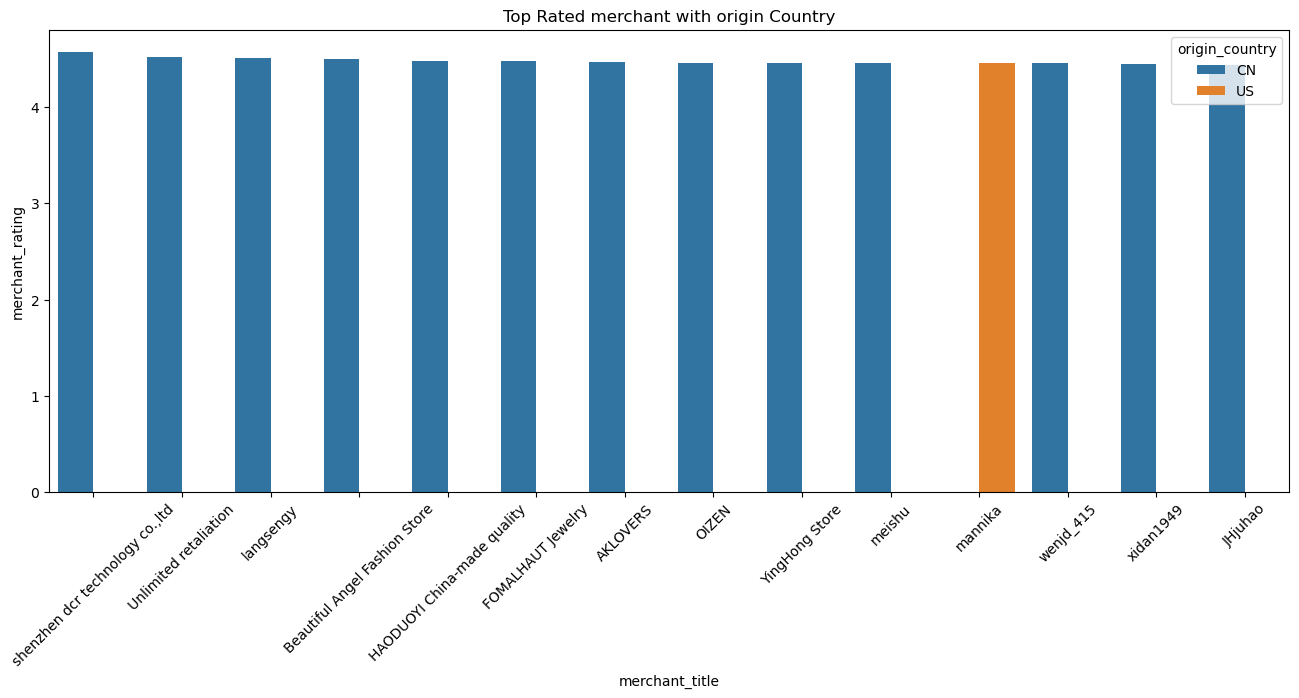

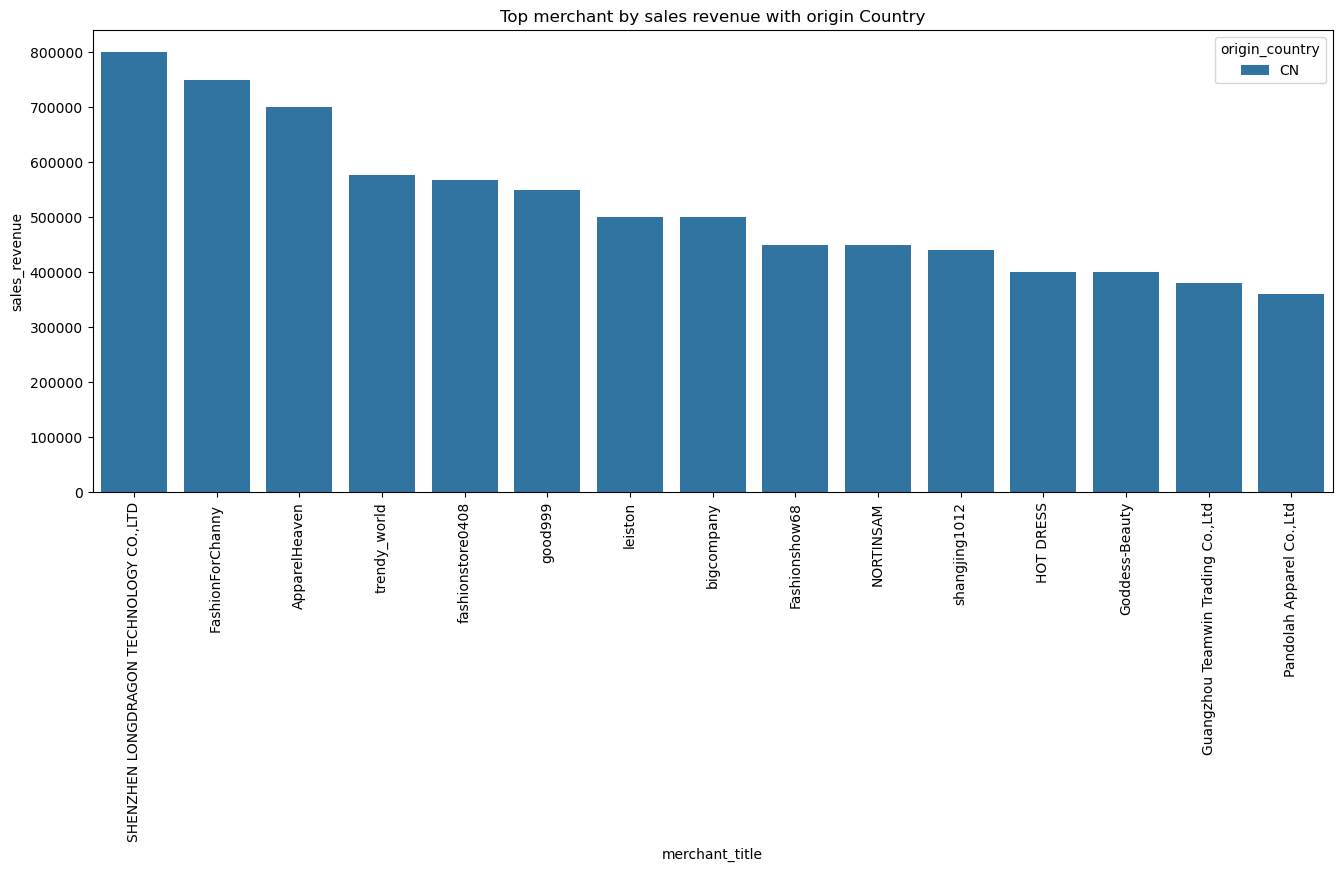

In [344]:
plt.figure(figsize=(16,6))
sns.barplot(x='merchant_title', y='merchant_rating', hue='origin_country',
            data=sumclo_df[sumclo_df['rating_count']>0][['merchant_title','origin_country','merchant_rating','merchant_rating_count']
                                       ].sort_values(by='merchant_rating', ascending=False).head(15))
plt.xticks(rotation=45)
plt.title('Top Rated merchant with origin Country')
plt.show()

plt.figure(figsize=(16,6))
sns.barplot(x='merchant_title', y='sales_revenue', hue='origin_country',
            data=sumclo_df[sumclo_df['rating_count']>0][['merchant_title','origin_country','merchant_rating','merchant_rating_count','sales_revenue']
                                       ].sort_values(by='sales_revenue', ascending=False).head(15))
plt.xticks(rotation=90)
plt.title('Top merchant by sales revenue with origin Country')
plt.show()

How many top rated merchant and its origin Country by merchant ratings after China

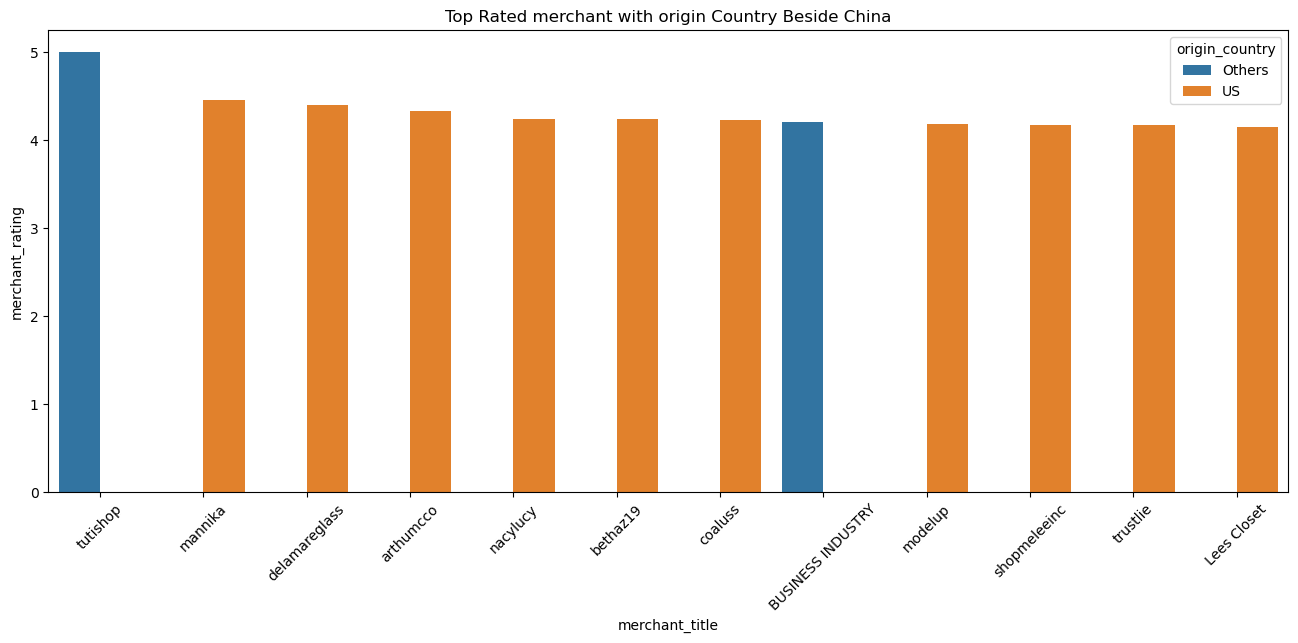

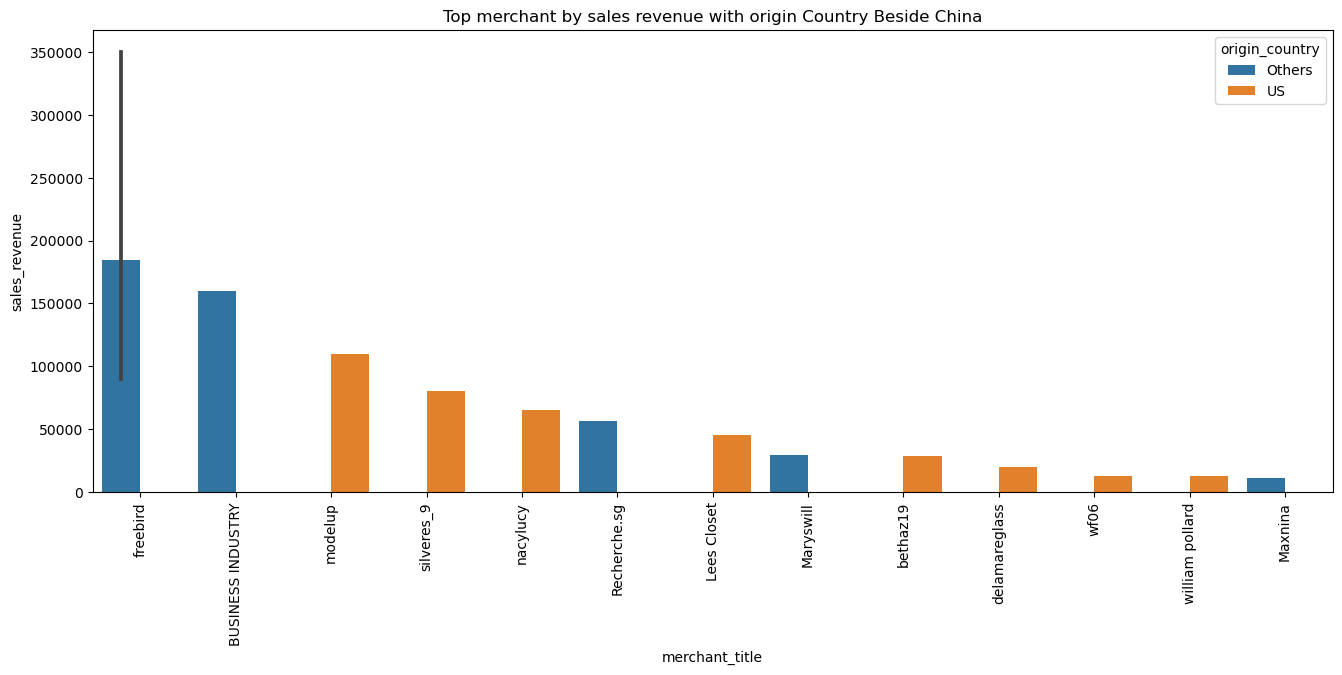

In [345]:
plt.figure(figsize=(16,6))
sns.barplot(x='merchant_title', y='merchant_rating', hue='origin_country',
            data=sumclo_df[(sumclo_df['origin_country']!='CN')][['merchant_title','origin_country','merchant_rating','merchant_rating_count']
                                       ].sort_values(by='merchant_rating', ascending=False).head(15))
plt.xticks(rotation=45)
plt.title('Top Rated merchant with origin Country Beside China')
plt.show()

plt.figure(figsize=(16,6))
sns.barplot(x='merchant_title', y='sales_revenue', hue='origin_country',
            data=sumclo_df[(sumclo_df['origin_country']!='CN')][['merchant_title','origin_country','merchant_rating','merchant_rating_count',
                        'sales_revenue']].sort_values(by='sales_revenue', ascending=False).head(15))
plt.xticks(rotation=90)
plt.title('Top merchant by sales revenue with origin Country Beside China')
plt.show()

In [396]:
features = sumclo_df[['product_category', 'product_color','product_variation_size_id','origin_country', 'merchant_title','price', 'retail_price', 
                      'units_sold', 'sales_revenue', 'retail_revenue', 'uses_ad_boosts', 'rating', 'rating_count','rating_five_count', 
                      'rating_four_count', 'rating_three_count', 'rating_two_count', 'rating_one_count','badges_count', 'badge_local_product', 
                      'badge_product_quality', 'badge_fast_shipping', 'has_urgency_banner', 'merchant_rating']]

# categorical encoding
lab_enc = LabelEncoder()
for categ in ['product_category', 'product_color','product_variation_size_id','origin_country', 'merchant_title']:
    features[categ] = lab_enc.fit_transform(features[categ])

C:\Users\Hendry\AppData\Local\Temp\ipykernel_8564\171172095.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[categ] = lab_enc.fit_transform(features[categ])


In [397]:
# numerical scaling
num_scal = MinMaxScaler()
feat_num = features[['price', 'retail_price', 'units_sold', 'sales_revenue', 'retail_revenue', 'uses_ad_boosts', 'rating', 
                'rating_count','rating_five_count', 'rating_four_count', 'rating_three_count', 'rating_two_count', 'rating_one_count', 
                'badges_count', 'badge_local_product', 'badge_product_quality', 'badge_fast_shipping','has_urgency_banner', 'merchant_rating']]
feat_num = num_scal.fit_transform(feat_num)
feat_num = pd.DataFrame(feat_num, columns=['price', 'retail_price', 'units_sold', 'sales_revenue', 'retail_revenue', 'uses_ad_boosts', 'rating', 
            'rating_count','rating_five_count', 'rating_four_count', 'rating_three_count', 'rating_two_count', 'rating_one_count', 'badges_count', 
                    'badge_local_product', 'badge_product_quality', 'badge_fast_shipping','has_urgency_banner', 'merchant_rating'])
features[['price', 'retail_price', 'units_sold', 'sales_revenue', 'retail_revenue', 'uses_ad_boosts', 'rating', 
            'rating_count','rating_five_count', 'rating_four_count', 'rating_three_count', 'rating_two_count', 'rating_one_count', 'badges_count', 
                    'badge_local_product', 'badge_product_quality', 'badge_fast_shipping','has_urgency_banner', 'merchant_rating']] = feat_num
features.fillna(0, inplace=True)
features

C:\Users\Hendry\AppData\Local\Temp\ipykernel_8564\2809632560.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[['price', 'retail_price', 'units_sold', 'sales_revenue', 'retail_revenue', 'uses_ad_boosts', 'rating',
C:\Users\Hendry\AppData\Local\Temp\ipykernel_8564\2809632560.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(0, inplace=True)


,product_category,product_color,product_variation_size_id,origin_country,merchant_title,price,retail_price,units_sold,sales_revenue,retail_revenue,...,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,has_urgency_banner,merchant_rating
0,6,91,50,0,924,0.312500,0.051793,0.000990,0.001997,0.000242,...,0.001927,0.002734,0.000499,0.003227,0.0,0.0,0.0,0.0,1.0,0.673195
1,1,41,93,0,284,0.145833,0.083665,0.199992,0.199997,0.076520,...,0.247351,0.305631,0.321518,0.386160,0.0,0.0,0.0,0.0,1.0,0.587377
2,10,49,93,0,571,0.145833,0.167331,0.000990,0.000997,0.000746,...,0.000963,0.000547,0.000000,0.001076,0.0,0.0,0.0,0.0,1.0,0.621186
3,6,14,50,0,407,0.145833,0.027888,0.049990,0.049997,0.006955,...,0.028661,0.023783,0.020969,0.012908,0.0,0.0,0.0,0.0,0.0,0.632663
4,5,101,55,0,898,0.035833,0.007968,0.000990,0.000337,0.000051,...,0.000963,0.000547,0.000999,0.002151,0.0,0.0,0.0,0.0,1.0,0.625596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,6,64,55,0,480,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1569,5,51,55,0,748,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1570,10,91,64,0,767,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1571,1,91,72,0,682,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


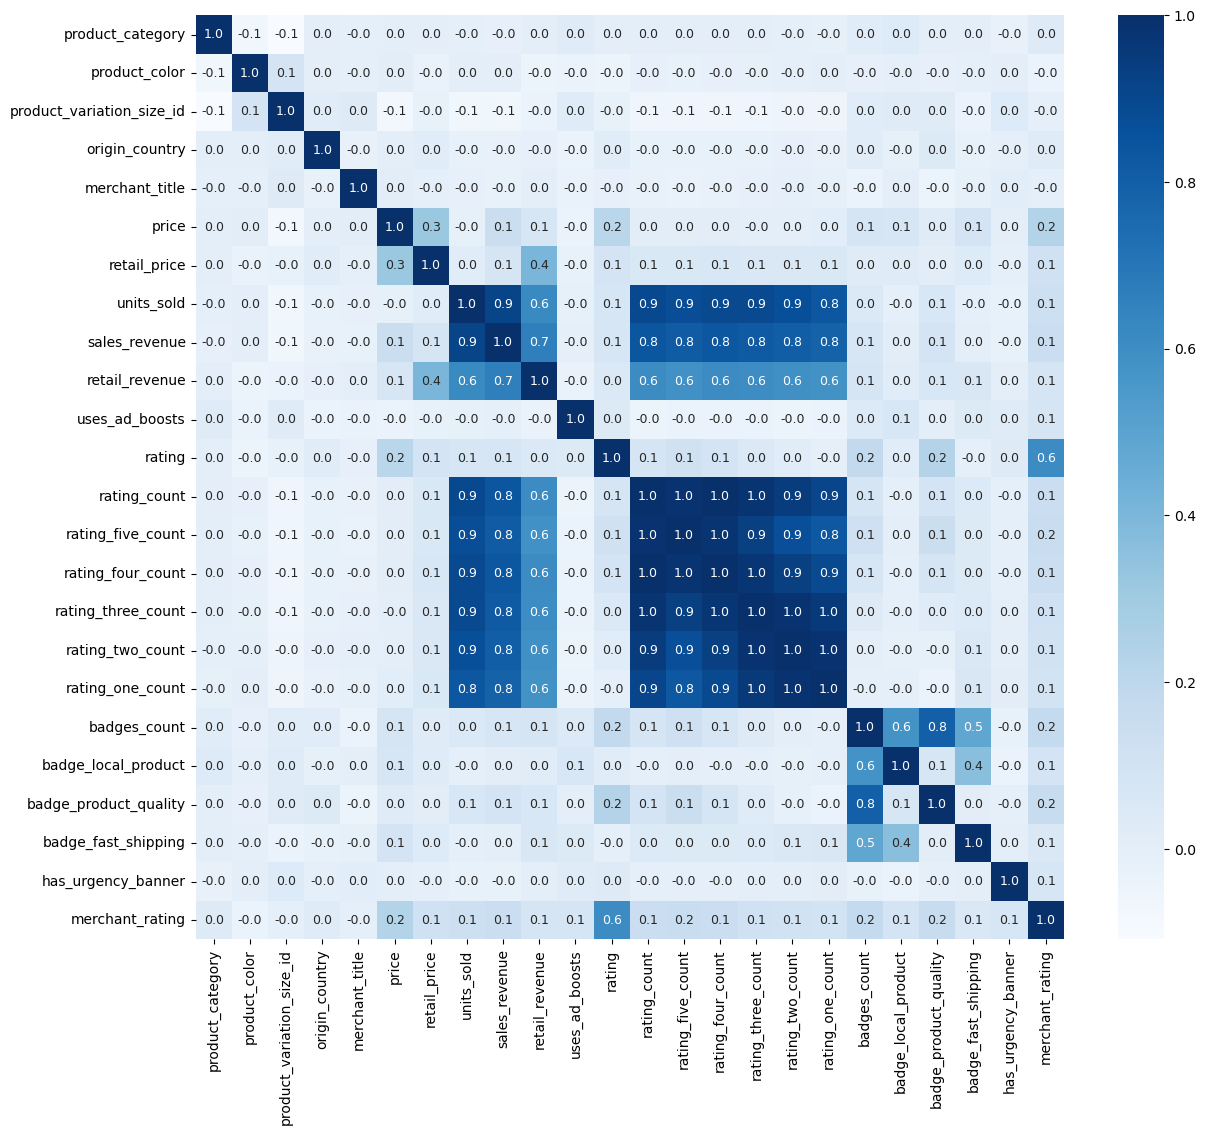

In [398]:
plt.figure(figsize=(14,12))
sns.heatmap(features.corr(), annot=True, fmt='.1f', cmap='Blues', annot_kws={'size':9})
plt.show()

In [412]:
# in features variable, removing unnecesary variable in multiple linear regression
X = features.drop(columns=['units_sold','sales_revenue','retail_revenue','badges_count','badge_local_product',
                           'badge_fast_shipping','has_urgency_banner','uses_ad_boosts','merchant_title'])
y = features['units_sold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

print(f'Training Data {X_train.shape[0]} Rows {X_train.shape[1]} Columns with {y_train.shape[0]} Labels Rows')
print(f'Testing Data {X_test.shape[0]} Rows {X_test.shape[1]} Columns with {y_test.shape[0]} Labels Rows')

Training Data 1154 Rows 15 Columns with 1154 Labels Rows
Testing Data 385 Rows 15 Columns with 385 Labels Rows


In [413]:
# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
linpred = linreg.predict(X_test)

print(f"""Linear Regression Score
Root Mean Squared Error : {np.sqrt(mean_squared_error(y_test, linpred)):.2f}
Mean Absolute Error     : {mean_absolute_error(y_test, linpred):.2f}
R2 Score                : {r2_score(y_test, linpred):.2f}""")

Linear Regression Score
Root Mean Squared Error : 0.03
Mean Absolute Error     : 0.02
R2 Score                : 0.85


In [414]:
# Ridge CV Regression
ridreg = RidgeCV(alphas=[1, 0.1, 0.01, 0.005], normalize=True)
ridreg.fit(X_train, y_train)
ridpred = ridreg.predict(X_test)

print(f"""Ridge CV Regression Score
Root Mean Squared Error : {np.sqrt(mean_squared_error(y_test, ridpred)):.2f}
Mean Absolute Error     : {mean_absolute_error(y_test, ridpred):.2f}
R2 Score                : {r2_score(y_test, ridpred):.2f}""")

Ridge CV Regression Score
Root Mean Squared Error : 0.03
Mean Absolute Error     : 0.02
R2 Score                : 0.85


c:\Users\Hendry\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [415]:
# Lasso CV Regression
lasreg = LassoCV(alphas=[1, 0.1, 0.01, 0.005], random_state=1)
lasreg.fit(X_train, y_train)
laspred = lasreg.predict(X_test)

print(f"""Lasso CV Regression Score
Root Mean Squared Error : {np.sqrt(mean_squared_error(y_test, laspred)):.2f}
Mean Absolute Error     : {mean_absolute_error(y_test, laspred):.2f}
R2 Score                : {r2_score(y_test, laspred):.2f}""")

Lasso CV Regression Score
Root Mean Squared Error : 0.04
Mean Absolute Error     : 0.03
R2 Score                : 0.61


In [416]:
# Decision Tree Regressor
treereg = DecisionTreeRegressor(criterion='squared_error')
treereg.fit(X_train, y_train)
treepred = treereg.predict(X_test)

print(f"""Lasso CV Regression Score
Root Mean Squared Error : {np.sqrt(mean_squared_error(y_test, treepred)):.2f}
Mean Absolute Error     : {mean_absolute_error(y_test, treepred):.2f}
R2 Score                : {r2_score(y_test, treepred):.2f}""")

Lasso CV Regression Score
Root Mean Squared Error : 0.04
Mean Absolute Error     : 0.01
R2 Score                : 0.58


In [432]:
# Random Forest Regressor
raforeg = RandomForestRegressor(criterion='squared_error')
raforeg.fit(X_train, y_train)
rafopred = raforeg.predict(X_test)

print(f"""Random Forest Regression Score
Root Mean Squared Error : {np.sqrt(mean_squared_error(y_test, rafopred)):.2f}
Mean Absolute Error     : {mean_absolute_error(y_test, rafopred):.2f}
R2 Score                : {r2_score(y_test, rafopred):.2f}""")

Random Forest Regression Score
Root Mean Squared Error : 0.03
Mean Absolute Error     : 0.01
R2 Score                : 0.83


In [418]:
linr2 = r2_score(y_test, linpred)
ridr2 = r2_score(y_test, ridpred)
lasr2 = r2_score(y_test, laspred)
treer2 = r2_score(y_test, treepred)
rafor2 = r2_score(y_test, rafopred)

regres_score = pd.DataFrame(data={'Model':['Linear Regression', 'Ridge CV Regression', 'Lasso CV Regression', 
                                           'Decision Tree Regressor', 'Random Forest Regressor'],
                                  'Score':[linr2, ridr2, lasr2, treer2, rafor2]})
regres_score.sort_values(by='Score', ascending=False, inplace=True)
# round artinya dibulankan jadi 2 angka dibelakang koma
regres_score.round(2)

,Model,Score
1,Ridge CV Regression,0.85
0,Linear Regression,0.85
4,Random Forest Regressor,0.83
2,Lasso CV Regression,0.61
3,Decision Tree Regressor,0.58


,Column,Feature Importance
7,rating_count,0.287
10,rating_three_count,0.234
11,rating_two_count,0.188
8,rating_five_count,0.161
9,rating_four_count,0.040
4,price,0.017
5,retail_price,0.014
1,product_color,0.012
12,rating_one_count,0.011
14,merchant_rating,0.011


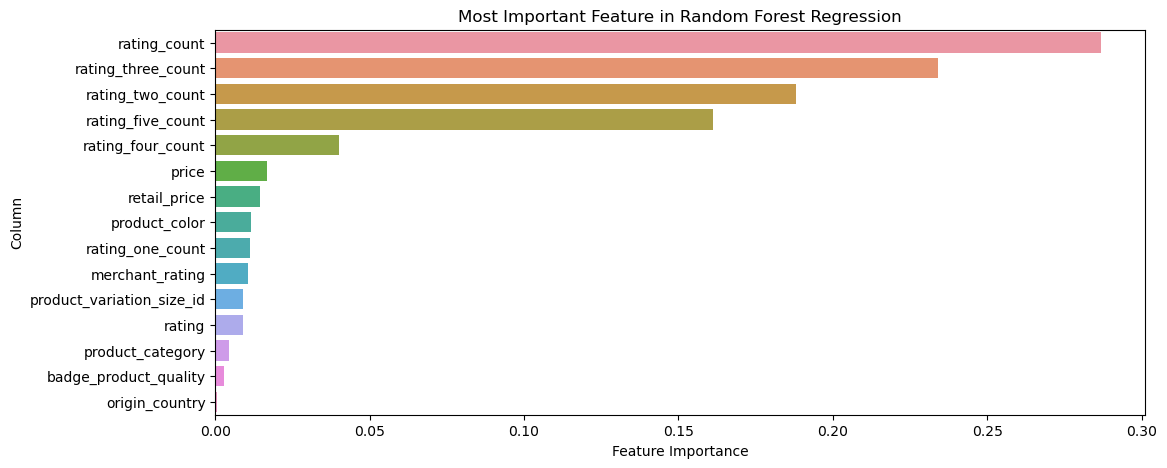

In [419]:
# Feature Importance Feature in Random Forest Regression menggunakan feature_importances_
rafoimp = pd.DataFrame(data={'Column':X.columns, 'Feature Importance':raforeg.feature_importances_})
rafoimp.sort_values(by='Feature Importance', ascending=False, inplace=True)
display(rafoimp.round(3))

# Most Important Feature in Random Forest Regression
plt.figure(figsize=(12,5))
sns.barplot(x='Feature Importance', y='Column', data=rafoimp)
plt.title('Most Important Feature in Random Forest Regression',fontsize=12)
plt.show()

,Column,Feature Importance
10,rating_three_count,1.157
8,rating_five_count,0.461
7,rating_count,0.303
14,merchant_rating,0.015
13,badge_product_quality,0.005
1,product_color,0.000
4,price,0.000
2,product_variation_size_id,-0.000
0,product_category,-0.000
3,origin_country,-0.002


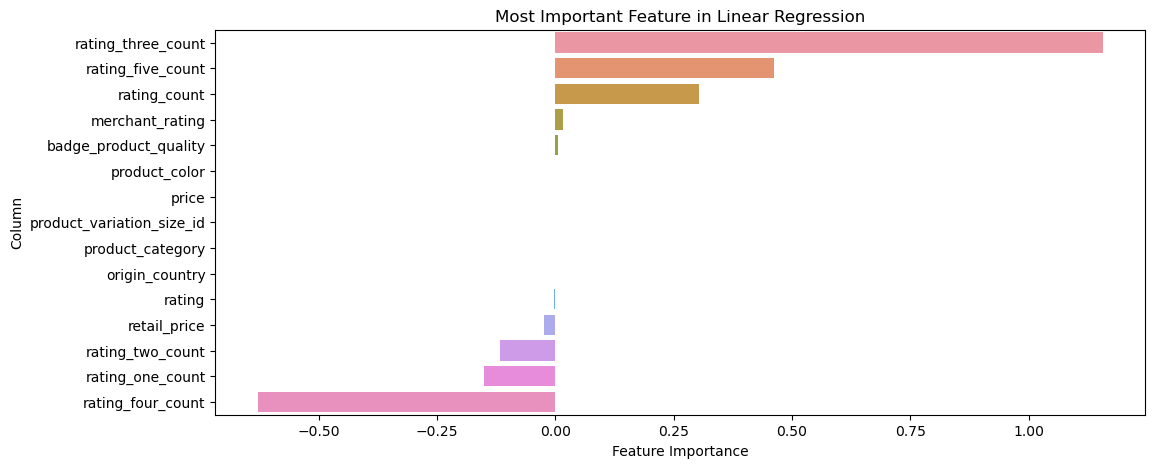

In [420]:
# Feature Coefficient in Linear Regression menggunakan coef_
linimp = pd.DataFrame(data={'Column':X.columns, 'Feature Importance':linreg.coef_})
linimp.sort_values(by='Feature Importance', ascending=False, inplace=True)
# round artinya dibulankan jadi 3 angka dibelakang koma
display(linimp.round(3))

# Most Important Feature in Linear Regression 
plt.figure(figsize=(12,5))
sns.barplot(x='Feature Importance', y='Column', data=linimp)
plt.title('Most Important Feature in Linear Regression',fontsize=12)
plt.show()

,Column,Feature Importance
8,rating_five_count,0.218
10,rating_three_count,0.210
11,rating_two_count,0.177
7,rating_count,0.167
9,rating_four_count,0.145
12,rating_one_count,0.072
14,merchant_rating,0.010
13,badge_product_quality,0.007
6,rating,0.003
1,product_color,0.000


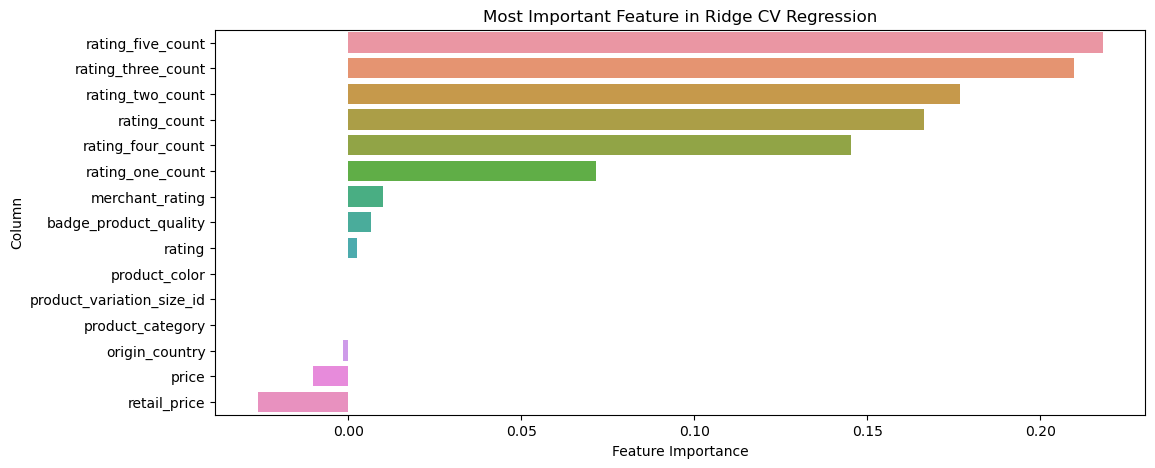

In [421]:
# Feature Coefficient in Ridge CV Regression menggunakan coef_
ridimp = pd.DataFrame(data={'Column':X.columns, 'Feature Importance':ridreg.coef_})
ridimp.sort_values(by='Feature Importance', ascending=False, inplace=True)
display(ridimp.round(3))

# Most Important Feature in Ridge CV Regression
plt.figure(figsize=(12,5))
sns.barplot(x='Feature Importance', y='Column', data=ridimp)
plt.title('Most Important Feature in Ridge CV Regression',fontsize=12)
plt.show()

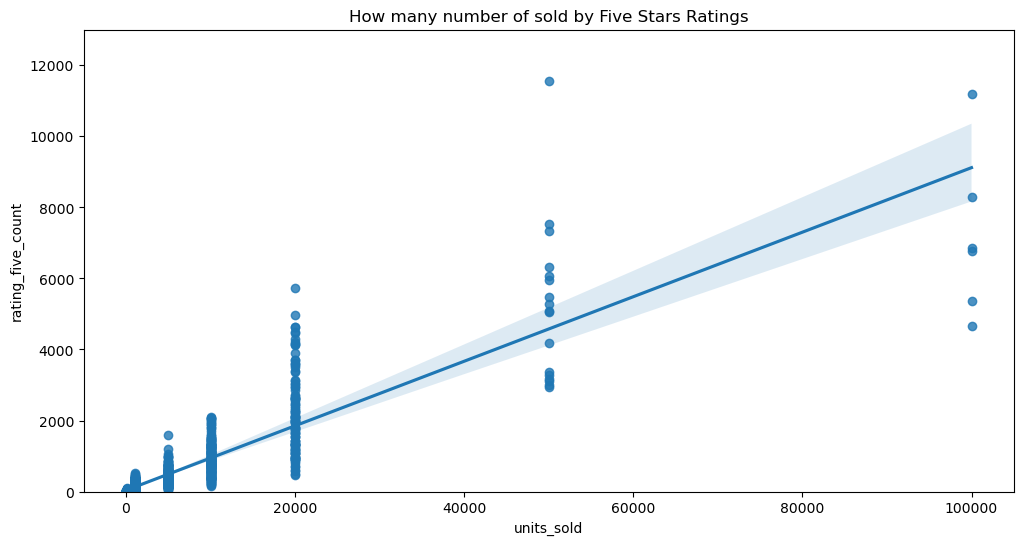

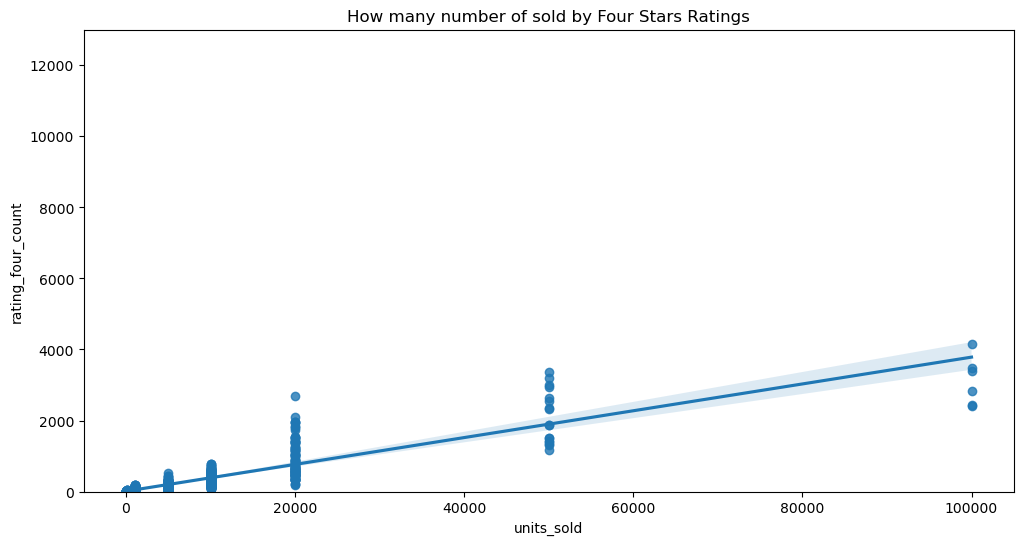

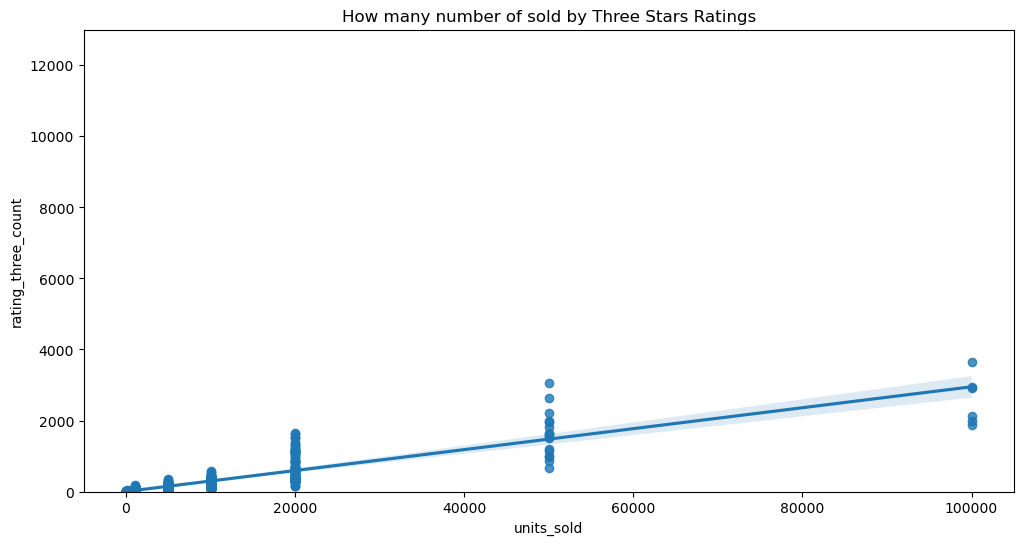

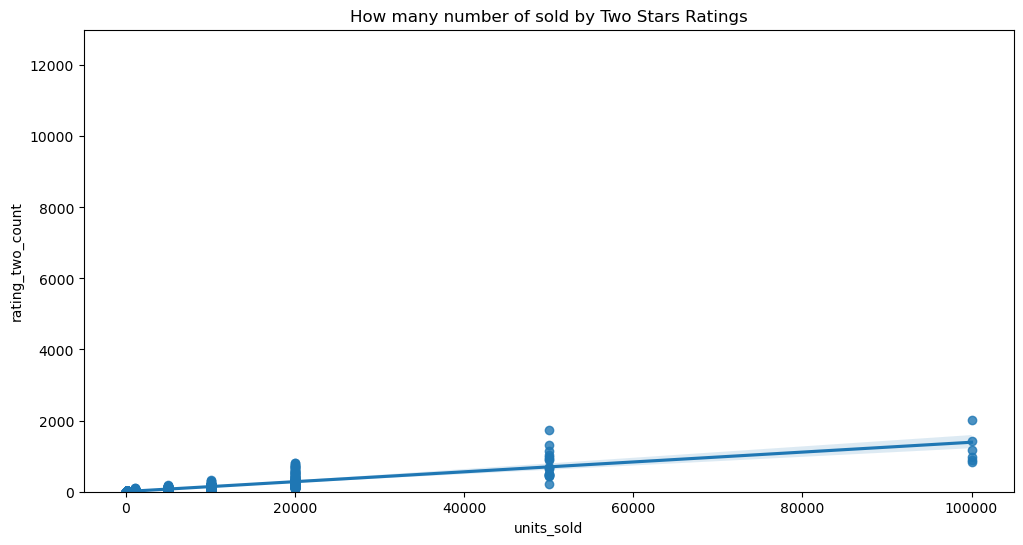

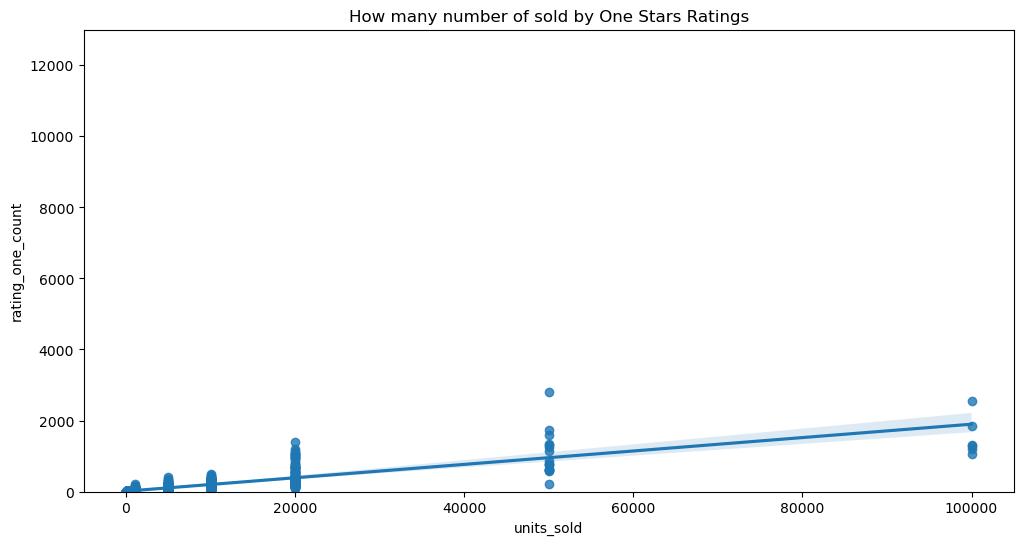

In [429]:
plt.figure(figsize=(12,6))
sns.regplot(x='units_sold', y='rating_five_count', data=sumclo_df).set_ylim(0, 13000)
plt.title('How many number of sold by Five Stars Ratings')
plt.show()

plt.figure(figsize=(12,6))
sns.regplot(x='units_sold', y='rating_four_count', data=sumclo_df).set_ylim(0, 13000)
plt.title('How many number of sold by Four Stars Ratings')
plt.show()

plt.figure(figsize=(12,6))
sns.regplot(x='units_sold', y='rating_three_count', data=sumclo_df).set_ylim(0, 13000)
plt.title('How many number of sold by Three Stars Ratings')
plt.show()

plt.figure(figsize=(12,6))
sns.regplot(x='units_sold', y='rating_two_count', data=sumclo_df).set_ylim(0, 13000)
plt.title('How many number of sold by Two Stars Ratings')
plt.show()

plt.figure(figsize=(12,6))
sns.regplot(x='units_sold', y='rating_one_count', data=sumclo_df).set_ylim(0, 13000)
plt.title('How many number of sold by One Stars Ratings')
plt.show()

In [430]:
# cleaned summer clothes df
# sumclo_df.to_csv('summer-clothes-with-rating-and-performance_cleaned.csv', index=False)